In [2]:
'''
Using Machine Learning to Denoise Quantum Observables
Developed by Kenny Heitritter (qBraid)
Copyright qBraid
'''

'\nUsing Machine Learning to Denoise Quantum Observables\nDeveloped by Kenny Heitritter (qBraid)\nCopyright qBraid\n'

In [3]:
from qiskit_aer.noise import (
    NoiseModel,
    pauli_error,
)

from typing import Any, Dict, List, Optional, Tuple, Union, cast


def get_quera_noise_model(config_quera_noise_factor=1.0):
    """
    Constructs a quantum noise model based on error parameters
    derived from the Bluvstein et al., Nature Vol 626, (2024) paper.

    Args:
        config_quera_noise_factor (float): A factor to scale the error probabilities.
                                           Default is 1.0 (no scaling).

    Returns:
        NoiseModel: The Qiskit Aer noise model.
    """
    quera_noise_model = NoiseModel()

    # 1. Reset error
    # Supported by SPAM error (Ref. [8] cited by paper) and measurement fidelity (paper p2, p10).
    # e.g., SPAM ~0.006, Meas_Error ~0.002 => Reset_Error ~0.004
    p_reset = 0.004 * config_quera_noise_factor
    error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
    quera_noise_model.add_all_qubit_quantum_error(error_reset, "reset")

    # 2. Measurement error
    # Paper (p2, Fig 1c; p10) mentions ~99.8% readout fidelity (0.002 error).
    # SPAM data from Ref. [8] also supports p_meas around 0.003.
    p_meas = 0.003 * config_quera_noise_factor
    error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
    quera_noise_model.add_all_qubit_quantum_error(error_meas, "measure")

    # 3. Entangling errors only for the active qubits in the CZ gate
    # Paper (p4, p9) states two-qubit gate fidelity of 99.5% (0.005 error).
    p_cz_active_qub = 0.005 * config_quera_noise_factor
    # The specific Pauli distribution X(p/4), Y(p/4), Z(p/2) is a modeling choice.
    cz_single_qubit_error = pauli_error(
        [
            ("X", 1 / 4 * p_cz_active_qub),
            ("Y", 1 / 4 * p_cz_active_qub),
            ("Z", 1 / 2 * p_cz_active_qub),
            ("I", 1 - p_cz_active_qub),
        ]
    )
    cz_error = cz_single_qubit_error.tensor(cz_single_qubit_error)
    quera_noise_model.add_quantum_error(
        cz_error, ["cx", "ecr", "cz"], [0,1] # Apply to specific qubits for 2Q gates
    )
    # To apply to all instances of 2Q gates if qubits are not specified
    # quera_noise_model.add_all_qubit_quantum_error(cz_error, ["cx", "ecr", "cz"]) # This is less precise for 2Q gates

    # 4. Single-qubit gate errors
    # p_u1: Supported by Ref. [8] (avg 1Q fidelity 99.94%, error 6e-4) and
    #       paper (p10, Raman scattering limit error ~7e-4).
    p_u1 = 5e-4 * config_quera_noise_factor
    # p_u2: Supported by paper (p10, local Z(pi/2) fidelity 99.912%, error ~8.8e-4).
    p_u2 = 1e-3 * config_quera_noise_factor
    # p_u3: Plausible for more complex/longer 1Q gates, qualitatively supported
    #       by paper's discussion of variable gate durations (p10, Ext. Data Fig. 2b).
    p_u3 = 1.5e-3 * config_quera_noise_factor

    # Depolarizing-like Pauli error model for single-qubit gates.
    sq_error_u1 = pauli_error(
        [
            ("X", 1 / 3 * p_u1),
            ("Y", 1 / 3 * p_u1),
            ("Z", 1 / 3 * p_u1),
            ("I", 1 - p_u1),
        ]
    )
    # Apply to gates corresponding to simpler/shorter rotations
    quera_noise_model.add_all_qubit_quantum_error(
        sq_error_u1, ["u1", "rz", "ry", "rx", "sx", "sxdg", "x", "y", "z", "h"] # Common 1Q gates
    )

    sq_error_u2 = pauli_error(
        [
            ("X", 1 / 3 * p_u2),
            ("Y", 1 / 3 * p_u2),
            ("Z", 1 / 3 * p_u2),
            ("I", 1 - p_u2),
        ]
    )
    # Apply to gates corresponding to moderately complex rotations (e.g., U2)
    quera_noise_model.add_all_qubit_quantum_error(sq_error_u2, ["u2"])

    sq_error_u3 = pauli_error(
        [
            ("X", 1 / 3 * p_u3),
            ("Y", 1 / 3 * p_u3),
            ("Z", 1 / 3 * p_u3),
            ("I", 1 - p_u3),
        ]
    )
    # Apply to gates corresponding to more complex rotations (e.g., U3)
    quera_noise_model.add_all_qubit_quantum_error(sq_error_u3, ["u3", "u"]) # u is a general 1Q gate

    return quera_noise_model

In [6]:
# Define parameters for data generation
num_circuits = 800
circuit_types = ['random'] # su(2) do for more structured circuits next


min_qubits = 2
max_qubits = 8
min_depth = 100
max_depth = 500
shots = 8192
noise_factor = 0.2
output_dir = "ml_mitigation_output"
seed = 42

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.data import Data, Batch
from qiskit.converters import circuit_to_dag
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# 1. First, add circuit-to-graph conversion function
def circuit_to_graph_data(circuit):
    """Convert a Qiskit circuit to a PyTorch Geometric graph"""
    dag = circuit_to_dag(circuit)
    
    # Map operations to indices
    op_types = {'x', 'h', 'cx', 'rz', 'ry', 'rx', 'p', 'u', 'u1', 'u2', 'u3', 'id', 'barrier', 'measure'}
    op_type_map = {op: i for i, op in enumerate(sorted(op_types))}
    
    # Create node features
    node_features = []
    node_map = {}
    
    # Get all nodes (proper method)
    op_nodes = list(dag.op_nodes())
    in_nodes = list(dag.input_map.values())
    out_nodes = list(dag.output_map.values())
    all_nodes = op_nodes + in_nodes + out_nodes
    
    # Create features for each node
    for i, node in enumerate(all_nodes):
        node_map[node] = i
        feature = torch.zeros(len(op_types) + 3)
        
        if node in op_nodes:  # Operation node
            op_name = node.op.name if hasattr(node.op, 'name') else str(node.op)
            op_idx = op_type_map.get(op_name.lower(), len(op_types) - 1)
            feature[op_idx] = 1.0
            
            # Add qubit position if available
            if node.qargs and len(node.qargs) > 0:
                try:
                    qubit_idx = circuit.find_bit(node.qargs[0]).index
                    feature[-1] = qubit_idx / max(1, circuit.num_qubits - 1)
                except:
                    feature[-1] = 0
        elif node in in_nodes:  # Input node
            feature[len(op_types)] = 1.0
        elif node in out_nodes:  # Output node
            feature[len(op_types) + 1] = 1.0
        
        node_features.append(feature)
    
    # Stack features into tensor
    node_features = torch.stack(node_features)
    
    # Create edge index by traversing the DAG
    edge_index = []
    
    # For each node, add edges to all its successors
    for node in all_nodes:
        if node in op_nodes or node in in_nodes:  # Don't get successors of output nodes
            successors = list(dag.successors(node))
            for succ in successors:
                if node in node_map and succ in node_map:
                    edge_index.append([node_map[node], node_map[succ]])
    
    # Convert to tensor
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    else:
        # Empty edge index fallback
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    
    return Data(x=node_features, edge_index=edge_index)

# 2. Define the model architecture
class QErrorMitigationModel(nn.Module):
    def __init__(self, depth=2):
        super().__init__()
        
        self.conv_layers = nn.ModuleList()
        in_channels = 17

        for i in range(depth):
            out_channels = 128 if i < depth-1 else 32
            self.conv_layers.append(GATv2Conv(in_channels=in_channels, out_channels=out_channels))
            in_channels = out_channels
        
        
        # Circuit encoder (GAT layers)
        # self.conv1 = GATv2Conv(in_channels=17, out_channels=128)  # 17 = feature dimensions from circuit_to_graph
        # # self.conv2 = GATv2Conv(in_channels=128, out_channels=64)
        # self.conv2 = GATv2Conv(in_channels=128, out_channels=32)
        
        # Observable encoder - small MLP for observable features
        self.obs_encoder = nn.Sequential(
            nn.Linear(5, 32),  # 5 = from extract_observable_features output size
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        
        # Noise model encoder (can be expanded later)
        self.noise_encoder = nn.Linear(1, 4)  # Just using noise_factor for now
        
        # Fusion network - now predicts the correction instead of the true value
        self.fusion = nn.Sequential(
            nn.Linear(32 + 8 + 4 + 1, 256),  # +1 for noisy expectation value
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output: correction to apply to noisy expectation value
        )
        
    def forward(self, circuit_data, observable_features, noise_factor, noisy_exp):
        # Process circuit graph
        x, edge_index, batch = circuit_data.x, circuit_data.edge_index, circuit_data.batch
        
        for conv in self.conv_layers:
            x = F.elu(conv(x, edge_index))
        # # Apply GAT layers
        # x = F.elu(self.conv1(x, edge_index))
        # x = self.conv2(x, edge_index)
        
        # Global pooling to get circuit embedding
        circuit_embedding = global_mean_pool(x, batch)
        
        # Process observable features
        obs_embedding = self.obs_encoder(observable_features)
        
        # Process noise information
        noise_embedding = self.noise_encoder(noise_factor)
        
        # Concatenate with noisy expectation value
        combined = torch.cat([
            circuit_embedding, 
            obs_embedding, 
            noise_embedding, 
            noisy_exp.view(-1, 1)
        ], dim=1)
        
        # Predict correction to noisy expectation value
        correction = self.fusion(combined)
        
        # Return the corrected expectation value (noisy + correction)
        return noisy_exp + correction

# 3. Create dataset preparation function
from qiskit.quantum_info.operators.base_operator import BaseOperator

def extract_observable_features(observable: BaseOperator) -> List[float]:
    """
    Extract features from an observable.
    
    Args:
        observable: The observable to extract features from
        
    Returns:
        List[float]: The extracted features
    """
    features = []
    
    # # Convert to SparsePauliOp if needed
    # if isinstance(observable, PauliSumOp):
    #     pauli_op = observable.primitive
    if hasattr(observable, 'to_pauli_op'):
        pauli_op = observable.to_pauli_op()
    else:
        # If we can't convert, return minimal features
        features.append(1.0)  # Number of terms
        features.append(0.0)  # Number of X terms
        features.append(0.0)  # Number of Y terms
        features.append(0.0)  # Number of Z terms
        features.append(0.0)  # Average weight
        return features
    
    # Number of terms
    features.append(float(len(pauli_op)))
    
    # Count Pauli types
    x_count = 0
    y_count = 0
    z_count = 0
    weights = []
    
    for pauli_string, _ in zip(pauli_op.paulis, pauli_op.coeffs):
        pauli_str = pauli_string.to_label()
        x_count += pauli_str.count('X')
        y_count += pauli_str.count('Y')
        z_count += pauli_str.count('Z')
        weight = len(pauli_str) - pauli_str.count('I')
        weights.append(weight)
    
    features.append(float(x_count))
    features.append(float(y_count))
    features.append(float(z_count))
    
    # Average weight
    avg_weight = np.mean(weights) if weights else 0.0
    features.append(float(avg_weight))
    
    return features

def prepare_mitigator_dataset(circuits, observables, noisy_values, noiseless_values, noise_factor):
    """Prepare dataset for the error mitigation model
    
    Args:
        circuits: List of quantum circuits or list of lists of circuits for multiple noise factors
        observables: List of observables or list of lists of observables for multiple noise factors
        noisy_values: List of noisy expectation values or list of lists for multiple noise factors
        noiseless_values: List of noiseless expectation values or list of lists for multiple noise factors
        noise_factor: Single noise factor value or list of noise factor values
    
    Returns:
        List of dictionaries containing the dataset entries
    """
    # from ml_qem.features import extract_observable_features
    
    dataset = []
    
    # Check if we have multiple noise factors
    if isinstance(noise_factor, (list, tuple, np.ndarray)):
        # Process multiple noise factors
        for nf_idx, nf in enumerate(noise_factor):
            # Get the corresponding data for this noise factor
            if isinstance(circuits[0], list):
                curr_circuits = circuits[nf_idx]
                curr_observables = observables[nf_idx]
                curr_noisy_values = noisy_values[nf_idx]
                curr_noiseless_values = noiseless_values[nf_idx]
            else:
                # If only noise_factor is a list but other inputs aren't lists of lists,
                # use the same data for each noise factor
                curr_circuits = circuits
                curr_observables = observables
                curr_noisy_values = noisy_values
                curr_noiseless_values = noiseless_values
            
            # Process the data for this noise factor
            for i in range(len(curr_circuits)):
                circuit_graph = circuit_to_graph_data(curr_circuits[i])
                obs_features = torch.tensor(extract_observable_features(curr_observables[i]), dtype=torch.float)
                correction = curr_noiseless_values[i] - curr_noisy_values[i]
                
                dataset.append({
                    'circuit_graph': circuit_graph,
                    'observable_features': obs_features,
                    'noise_factor': torch.tensor([nf], dtype=torch.float),
                    'noisy_exp': torch.tensor([curr_noisy_values[i]], dtype=torch.float),
                    'true_exp': torch.tensor([curr_noiseless_values[i]], dtype=torch.float),
                    'correction': torch.tensor([correction], dtype=torch.float),
                    'circuit': curr_circuits[i]
                })
    else:
        # Original single noise factor case
        for i in range(len(circuits)):
            # Convert circuit to graph
            circuit_graph = circuit_to_graph_data(circuits[i])
            
            # Extract observable features
            obs_features = torch.tensor(extract_observable_features(observables[i]), dtype=torch.float)
            
            # Calculate the correction (true - noisy)
            correction = noiseless_values[i] - noisy_values[i]
            
            # Store as dictionary
            dataset.append({
                'circuit_graph': circuit_graph,
                'observable_features': obs_features,
                'noise_factor': torch.tensor([noise_factor], dtype=torch.float),
                'noisy_exp': torch.tensor([noisy_values[i]], dtype=torch.float),
                'true_exp': torch.tensor([noiseless_values[i]], dtype=torch.float),
                'correction': torch.tensor([correction], dtype=torch.float),
                'circuit': circuits[i]
            })
    
    return dataset

# 4. Define training function
def train_mitigator(dataset, model, epochs=100, batch_size=32, lr=0.001, device='cpu'):
    """Train the error mitigation model"""
    
    # Split into train/validation
    train_size = int(0.8 * len(dataset))
    train_dataset = dataset[:train_size]
    val_dataset = dataset[train_size:]
    
    # Create data loaders with custom collate function
    def collate_fn(batch):
        # Collate circuit graphs
        graphs = [item['circuit_graph'] for item in batch]
        circuit_batch = Batch.from_data_list(graphs)
        
        # Collate other features
        obs_batch = torch.stack([item['observable_features'] for item in batch])
        noise_batch = torch.stack([item['noise_factor'] for item in batch])
        noisy_exp_batch = torch.stack([item['noisy_exp'] for item in batch])
        true_exp_batch = torch.stack([item['true_exp'] for item in batch])
        correction_batch = torch.stack([item['correction'] for item in batch])
        
        return {
            'circuit_data': circuit_batch,
            'observable_features': obs_batch,
            'noise_factor': noise_batch,
            'noisy_exp': noisy_exp_batch,
            'true_exp': true_exp_batch,
            'correction': correction_batch
        }
    
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    model = model.to(device)
    
    # Store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': [],
        'epoch_times': []
    }
    
    # Training loop
    for epoch in range(epochs):
        epoch_start_time = time.time()
        # Training phase
        model.train()
        train_loss = 0
        
        # Use tqdm with leave=False to avoid flooding output
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            # Move data to device
            circuit_data = batch['circuit_data'].to(device)
            obs_features = batch['observable_features'].to(device)
            noise_factor = batch['noise_factor'].to(device)
            noisy_exp = batch['noisy_exp'].to(device)
            true_exp = batch['true_exp'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            corrected_exp = model(circuit_data, obs_features, noise_factor, noisy_exp)
            
            # Compute loss against true expectation values
            loss = criterion(corrected_exp, true_exp)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                circuit_data = batch['circuit_data'].to(device)
                obs_features = batch['observable_features'].to(device)
                noise_factor = batch['noise_factor'].to(device)
                noisy_exp = batch['noisy_exp'].to(device)
                true_exp = batch['true_exp'].to(device)
                
                # Forward pass
                corrected_exp = model(circuit_data, obs_features, noise_factor, noisy_exp)
                
                # Compute loss
                loss = criterion(corrected_exp, true_exp)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        epoch_time = time.time() - epoch_start_time
        
        # Store training metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        history['epoch_times'].append(epoch_time)
        
        # Only print every 10 epochs to avoid flooding output
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}, Time: {epoch_time:.2f}s")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_val_loss': best_val_loss,
            }, 'best_quantum_mitigator.pt')
    
    # Save final model and training history
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
        'final_train_loss': train_loss,
        'final_val_loss': val_loss,
        'best_val_loss': best_val_loss,
    }, 'final_quantum_mitigator.pt')
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.yscale('log')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(history['learning_rates'])
    plt.yscale('log')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    os.makedirs("ml_mitigation_output", exist_ok=True)
    plt.savefig(os.path.join("ml_mitigation_output", "training_history.png"))
    
    return model, history

# 5. Add evaluation and visualization functions
def evaluate_mitigator(model, test_dataset, device='cpu', output_prefix="ml_mitigation_output"):
    """Evaluate error mitigation model performance"""
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    
    # Check if model is a tuple (model, history) and extract just the model
    if isinstance(model, tuple) and len(model) > 0:
        model = model[0]
    
    # Use same collate function as in training
    def collate_fn(batch):
        graphs = [item['circuit_graph'] for item in batch]
        circuit_batch = Batch.from_data_list(graphs)
        
        obs_batch = torch.stack([item['observable_features'] for item in batch])
        noise_batch = torch.stack([item['noise_factor'] for item in batch])
        noisy_exp_batch = torch.stack([item['noisy_exp'] for item in batch])
        true_exp_batch = torch.stack([item['true_exp'] for item in batch])
        
        return {
            'circuit_data': circuit_batch,
            'observable_features': obs_batch,
            'noise_factor': noise_batch,
            'noisy_exp': noisy_exp_batch,
            'true_exp': true_exp_batch
        }
    
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
    
    # Evaluation
    model.eval()
    predictions = []
    true_values = []
    noisy_values = []
    corrections = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            circuit_data = batch['circuit_data'].to(device)
            obs_features = batch['observable_features'].to(device)
            noise_factor = batch['noise_factor'].to(device)
            noisy_exp = batch['noisy_exp'].to(device)
            
            # Get predictions (corrected values)
            corrected_exp = model(circuit_data, obs_features, noise_factor, noisy_exp)
            
            # Calculate the applied corrections
            applied_corrections = (corrected_exp - noisy_exp).cpu().numpy().flatten()
            
            # Store results
            predictions.extend(corrected_exp.cpu().numpy().flatten())
            true_values.extend(batch['true_exp'].numpy().flatten())
            noisy_values.extend(batch['noisy_exp'].numpy().flatten())
            corrections.extend(applied_corrections)
    
    # Calculate errors
    noisy_error = np.abs(np.array(true_values) - np.array(noisy_values))
    mitigated_error = np.abs(np.array(true_values) - np.array(predictions))
    
    # Print statistics
    print("\nError Mitigation Results:")
    print(f"  Mean noisy error: {np.mean(noisy_error):.6f}")
    print(f"  Mean mitigated error: {np.mean(mitigated_error):.6f}")
    print(f"  Error reduction: {(1 - np.mean(mitigated_error)/np.mean(noisy_error))*100:.2f}%")
    print(f"  Mean correction applied: {np.mean(np.abs(corrections)):.6f}")
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Compare mitigated vs true values
    plt.subplot(2, 2, 1)
    plt.scatter(noisy_values, true_values, alpha=0.5, label='Noisy')
    plt.scatter(predictions, true_values, alpha=0.5, label='Mitigated')
    plt.plot([min(true_values), max(true_values)], 
            [min(true_values), max(true_values)], 'k--')
    plt.xlabel("Expectation Value")
    plt.ylabel("True Expectation Value")
    plt.legend()
    plt.title("Mitigation Performance")
    
    # Plot 2: Error distribution
    plt.subplot(2, 2, 2)
    plt.hist(noisy_error, alpha=0.5, bins=20, label='Noisy Error')
    plt.hist(mitigated_error, alpha=0.5, bins=20, label='Mitigated Error')
    plt.xlabel("Absolute Error")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Error Distribution")
    
    # Plot 3: Corrections applied
    plt.subplot(2, 2, 3)
    plt.hist(corrections, bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Correction Applied")
    plt.ylabel("Count")
    plt.title("Distribution of Applied Corrections")
    
    # Plot 4: Correction vs Error
    plt.subplot(2, 2, 4)
    ideal_corrections = np.array(true_values) - np.array(noisy_values)
    plt.scatter(ideal_corrections, corrections, alpha=0.5)
    plt.plot([min(ideal_corrections), max(ideal_corrections)], 
             [min(ideal_corrections), max(ideal_corrections)], 'k--')
    plt.xlabel("Ideal Correction")
    plt.ylabel("Applied Correction")
    plt.title("Correction Accuracy")
    
    plt.tight_layout()
    os.makedirs(output_prefix, exist_ok=True)
    plt.savefig(os.path.join(output_prefix, "mitigation_results.png"))
    
    # Save evaluation results - convert numpy arrays to standard Python types to ensure JSON serialization
    evaluation_results = {
        'predictions': [float(p) for p in predictions],
        'true_values': [float(v) for v in true_values],
        'noisy_values': [float(v) for v in noisy_values],
        'corrections': [float(c) for c in corrections],
        'noisy_error': [float(e) for e in noisy_error],
        'mitigated_error': [float(e) for e in mitigated_error],
        'mean_noisy_error': float(np.mean(noisy_error)),
        'mean_mitigated_error': float(np.mean(mitigated_error)),
        'mean_correction': float(np.mean(np.abs(corrections))),
        'error_reduction_percentage': float((1 - np.mean(mitigated_error)/np.mean(noisy_error))*100)
    }
    
    import json
    with open(os.path.join(output_prefix, "evaluation_results.json"), 'w') as f:
        json.dump(evaluation_results, f, indent=2)
    
    return predictions, true_values, noisy_values


import os
import time
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer.primitives import Estimator as AerEstimator


from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.random import random_circuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import SparsePauliOp

# from ml_qem.data import (
#     generate_random_observables,
#     create_depolarizing_noise_model,
#     generate_training_data
# )


def generate_proper_circuits(
    num_circuits: int = 500,
    min_qubits: int = 2,
    max_qubits: int = 6,
    min_depth: int = 50,
    max_depth: int = 200,
    seed: int = 42,
    circuit_types: list = ['random', 'su2']
):
    """
    Generate proper quantum circuits with actual gates.
    
    Args:
        num_circuits: Number of circuits to generate
        min_qubits: Minimum number of qubits
        max_qubits: Maximum number of qubits
        min_depth: Minimum circuit depth
        max_depth: Maximum circuit depth
        seed: Random seed
        
    Returns:
        List[QuantumCircuit]: Generated circuits
    """
    np.random.seed(seed)
    circuits = []
    
    # Generate random circuits
    if 'random' in circuit_types:
        for i in range(num_circuits):
            # Random number of qubits and depth
            num_qubits = np.random.randint(min_qubits, max_qubits + 1)
            depth = np.random.randint(min_depth, max_depth + 1)
            
            # Generate random circuit
            circuit = random_circuit(
                num_qubits=num_qubits,
                depth=depth,
                max_operands=2,
                measure=False,
                seed=seed + i
            )
            
            circuit.name = f"random_circuit_{i}"
            circuits.append(circuit)
    
    # Generate EfficientSU2 circuits (similar to hardware-efficient ansatz)
    if 'su2' in circuit_types:
        for i in range(num_circuits):
            # Random number of qubits and depth
            num_qubits = np.random.randint(min_qubits, max_qubits + 1)
            reps = np.random.randint(1, 5)  # Number of repetitions
            
            # Generate EfficientSU2 circuit template
            circuit_template = EfficientSU2(
                num_qubits=num_qubits,
                reps=reps,
                entanglement='linear'
            )
            
            # Convert to QuantumCircuit
            circuit = circuit_template.decompose()
            
            # Add random parameters
            params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)
            bound_circuit = circuit.assign_parameters(params)
            
            bound_circuit.name = f"efficient_su2_{i}"
            circuits.append(bound_circuit)
    
    # Generate UCCSD-like circuits (with CNOT ladders and rotations)
    if 'uccsd' in circuit_types:
        for i in range(num_circuits):
            # Random number of qubits
            num_qubits = np.random.randint(min_qubits, max_qubits + 1)
            
            # Create circuit
            circuit = QuantumCircuit(num_qubits)
            
            # Add initial Hadamard layer
            for q in range(num_qubits):
                circuit.h(q)
            
            depth = np.random.randint(min_depth, max_depth)
            for i in range(depth):
                start_q = np.random.randint(0, num_qubits - 1)
                end_q = np.random.randint(start_q + 1, num_qubits)
                if end_q == start_q: # ensure at least one CX
                    if start_q < num_qubits -1: end_q = start_q + 1
                    else: continue # skip if not possible

                # Forward ladder on subset
                for q in range(start_q, end_q):
                    circuit.cx(q, q + 1)

                # Rotations (maybe only on involved qubits or all)
                for q in range(num_qubits): # Or range(start_q, end_q + 1)
                    angle = np.random.uniform(0, 2*np.pi)
                    circuit.rz(angle, q)

                # Backward ladder on subset
                for q in range(end_q - 1, start_q - 1, -1):
                    circuit.cx(q, q + 1) # Still cx(q, q+1) but iterating downwards
                                        # or to be truly "backward": circuit.cx(q, q-1) if q > start_q
                                        # For true reversal of CX(q, q+1) it's more complex, often involving H gates
                                        # or simply reversing the order of application:
                # Backward ladder (applied in reverse order of forward)
                for q in range(end_q -1, start_q -1, -1): # Iterate from end_q-1 down to start_q
                    circuit.cx(q, q + 1)
            
            circuit.name = f"uccsd_like_{i}"
            circuits.append(circuit)
    
    return circuits

def generate_proper_observables(circuits, max_terms=8, seed=42):
    """
    Generate proper observables for the circuits.
    
    Args:
        circuits: List of quantum circuits
        max_terms: Maximum number of terms in each observable
        seed: Random seed
        
    Returns:
        List[SparsePauliOp]: Generated observables
    """
    np.random.seed(seed)
    observables = []
    
    for circuit in circuits:
        num_qubits = circuit.num_qubits
        num_terms = np.random.randint(1, max_terms + 1)
        
        # Generate Pauli strings
        pauli_strings = []
        coeffs = []
        
        for _ in range(num_terms):
            # Generate a random Pauli string
            pauli_ops = np.random.choice(['I', 'X', 'Y', 'Z'], size=num_qubits)
            pauli_string = ''.join(pauli_ops)
            
            # Generate a random coefficient
            coeff = np.random.uniform(-1, 1)
            
            pauli_strings.append(pauli_string)
            coeffs.append(coeff)
        
        # Create observable
        observable = SparsePauliOp(pauli_strings, coeffs)
        observables.append(observable)
    
    return observables




Processing noise factor: 1.0
Running noiseless simulations...
Running noisy simulations...
  Noise factor 1.0 statistics:
    Mean absolute error: 0.126729
    Max absolute error: 1.541713
    Min absolute error: 0.000000
Saved visualization to ml_mitigation_output/noise_factor_1.0/expectation_values_nf_1.0.png

Overall summary statistics:
  Total data points: 800
  Mean absolute error: 0.126729
  Max absolute error: 1.541713
  Min absolute error: 0.000000
  Standard deviation of error: 0.174255
Saved combined visualization to ml_mitigation_output/noise_factor_1.0/expectation_values_combined.png
Preparing dataset for DAG-based error mitigation model...
Dataset split: 640 training samples, 160 test samples
Number of shared circuit hashes between training and test sets: 0


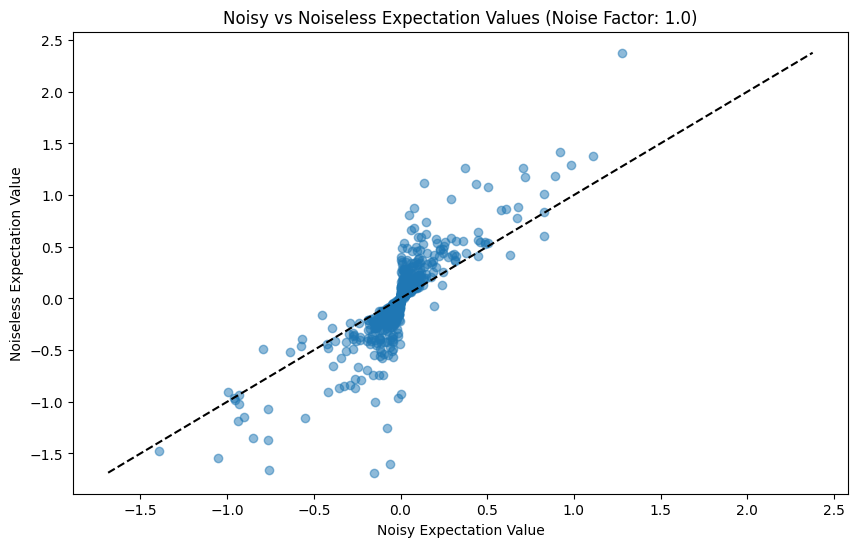

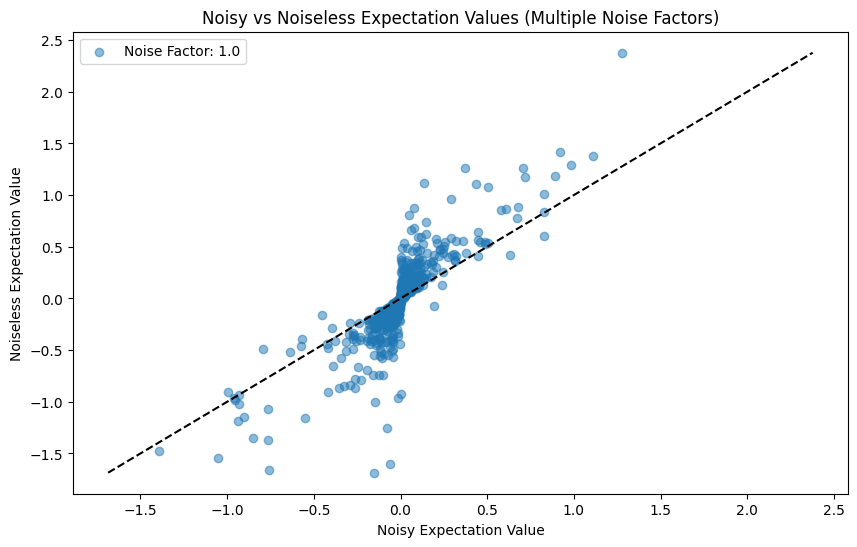

In [7]:
# Generate proper circuits
circuits = generate_proper_circuits(
    num_circuits=num_circuits,
    min_qubits=min_qubits,
    max_qubits=max_qubits,
    min_depth=min_depth,
    max_depth=max_depth,
    seed=seed,
    circuit_types=circuit_types
)

observables = generate_proper_observables(circuits, seed=seed)

# Create a combined dataset with multiple noise factors
# noise_factors = [1.0, 1.2, 1.4]
noise_factors = [1.0]

all_circuits_by_nf = []
all_observables_by_nf = []
all_noisy_values_by_nf = []
all_noiseless_values_by_nf = []

# Run simulations for each noise factor
for noise_factor in noise_factors:
    output_dir = f"ml_mitigation_output/noise_factor_{noise_factor}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nProcessing noise factor: {noise_factor}")
    
    noise_model = get_quera_noise_model(noise_factor)
    
    noiseless_estimator_options = {
        "run_options": {"seed": seed, "shots": None},
        "backend_options": {
            "method": "statevector",
            "enable_truncation": True,
            "device": "CPU",
            "noise_model": None,
            "shots": None,
        },
        "transpile_options": {"seed_transpiler": seed},
        "approximation": True,
    }
    
    noisy_estimator_options = {
        "run_options": {"seed": seed, "shots": None},
        "backend_options": {
            "method": "density_matrix",
            "enable_truncation": True,
            "device": "CPU",
            "noise_model": noise_model,
            "shots": None,
        },
        "transpile_options": {"seed_transpiler": seed},
        "approximation": True,
    }
    
    # Create estimators
    noiseless_estimator = AerEstimator(**noiseless_estimator_options)
    noisy_estimator = AerEstimator(**noisy_estimator_options)
    
    # Prepare parameter values (empty for non-parameterized circuits)
    parameter_values = [[] for _ in range(len(circuits))]
    
    # Run noiseless simulations
    print("Running noiseless simulations...")
    noiseless_job = noiseless_estimator.run(
        circuits=circuits,
        observables=observables,
        parameter_values=parameter_values
    )
    noiseless_result = noiseless_job.result()
    noiseless_values = noiseless_result.values
    
    # Run noisy simulations
    print("Running noisy simulations...")
    noisy_job = noisy_estimator.run(
        circuits=circuits,
        observables=observables,
        parameter_values=parameter_values
    )
    noisy_result = noisy_job.result()
    noisy_values = noisy_result.values
    
    # Store data for this noise factor
    curr_noisy_values = [float(val) for val in noisy_values]
    curr_noiseless_values = [float(val) for val in noiseless_values]
    
    all_circuits_by_nf.append(circuits)
    all_observables_by_nf.append(observables)
    all_noisy_values_by_nf.append(curr_noisy_values)
    all_noiseless_values_by_nf.append(curr_noiseless_values)
    
    # Print summary statistics for this noise factor
    error = np.abs(np.array(noiseless_values) - np.array(noisy_values))
    print(f"  Noise factor {noise_factor} statistics:")
    print(f"    Mean absolute error: {np.mean(error):.6f}")
    print(f"    Max absolute error: {np.max(error):.6f}")
    print(f"    Min absolute error: {np.min(error):.6f}")
    
    # Create visualization for this noise factor
    plt.figure(figsize=(10, 6))
    plt.scatter([float(v) for v in noisy_values], [float(v) for v in noiseless_values], alpha=0.5)
    plt.plot([min([float(v) for v in noiseless_values]), max([float(v) for v in noiseless_values])], 
             [min([float(v) for v in noiseless_values]), max([float(v) for v in noiseless_values])], 'k--')
    plt.xlabel("Noisy Expectation Value")
    plt.ylabel("Noiseless Expectation Value")
    plt.title(f"Noisy vs Noiseless Expectation Values (Noise Factor: {noise_factor})")
    plt.savefig(os.path.join(output_dir, f"expectation_values_nf_{noise_factor}.png"))
    print(f"Saved visualization to {os.path.join(output_dir, f'expectation_values_nf_{noise_factor}.png')}")

# Print overall summary statistics
all_noisy_flat = [val for sublist in all_noisy_values_by_nf for val in sublist]
all_noiseless_flat = [val for sublist in all_noiseless_values_by_nf for val in sublist]
error = np.abs(np.array(all_noiseless_flat) - np.array(all_noisy_flat))

print("\nOverall summary statistics:")
print(f"  Total data points: {len(all_noisy_flat)}")
print(f"  Mean absolute error: {np.mean(error):.6f}")
print(f"  Max absolute error: {np.max(error):.6f}")
print(f"  Min absolute error: {np.min(error):.6f}")
print(f"  Standard deviation of error: {np.std(error):.6f}")

# Create combined visualization
plt.figure(figsize=(10, 6))
for i, nf in enumerate(noise_factors):
    plt.scatter(
        all_noisy_values_by_nf[i],
        all_noiseless_values_by_nf[i],
        alpha=0.5,
        label=f"Noise Factor: {nf}"
    )
plt.plot([min(all_noiseless_flat), max(all_noiseless_flat)], 
         [min(all_noiseless_flat), max(all_noiseless_flat)], 'k--')
plt.xlabel("Noisy Expectation Value")
plt.ylabel("Noiseless Expectation Value")
plt.title("Noisy vs Noiseless Expectation Values (Multiple Noise Factors)")
plt.legend()
plt.savefig(os.path.join(output_dir, "expectation_values_combined.png"))
print(f"Saved combined visualization to {os.path.join(output_dir, 'expectation_values_combined.png')}")

# Convert your data to the format needed for the DAG-based model
print("Preparing dataset for DAG-based error mitigation model...")
dataset = prepare_mitigator_dataset(
    all_circuits_by_nf,  # List of lists of circuits for each noise factor
    all_observables_by_nf,  # List of lists of observables for each noise factor
    all_noisy_values_by_nf,  # List of lists of noisy values for each noise factor
    all_noiseless_values_by_nf,  # List of lists of noiseless values for each noise factor
    noise_factors  # List of noise factors
)

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"Dataset split: {len(train_dataset)} training samples, {len(test_dataset)} test samples")


from qiskit import qasm3
import hashlib
def qasm_hash(circ: QuantumCircuit) -> str:
    """Creates a stable hash from a circuit's QASM3 representation."""
    try:
        qasm = qasm3.dumps(circ)
        return hashlib.sha256(qasm.encode()).hexdigest()
    except Exception:
        # Fallback for circuits that might have issues with QASM3 conversion
        return hashlib.sha256(str(circ.data).encode()).hexdigest()
    
train_hashes = []
for data in train_dataset:
    hash = qasm_hash(data['circuit'])
    train_hashes.append(hash)

test_hashes = []
for data in test_dataset:
    hash = qasm_hash(data['circuit'])
    test_hashes.append(hash)

# Determine the number of hashes that are shared between train and test sets
train_hashes_set = set(train_hashes)
test_hashes_set = set(test_hashes)
shared_hashes = train_hashes_set.intersection(test_hashes_set)
print(f"Number of shared circuit hashes between training and test sets: {len(shared_hashes)}")



Using device: cpu
Training error mitigation model...


Epoch 1/100, Train Loss: 0.058404, Val Loss: 0.026280, LR: 0.001000, Time: 4.11s


Epoch 10/100, Train Loss: 0.040246, Val Loss: 0.022426, LR: 0.001000, Time: 3.73s


Epoch 20/100, Train Loss: 0.034050, Val Loss: 0.017842, LR: 0.001000, Time: 3.84s


Epoch 30/100, Train Loss: 0.029486, Val Loss: 0.014420, LR: 0.001000, Time: 3.98s


Epoch 40/100, Train Loss: 0.022908, Val Loss: 0.013757, LR: 0.001000, Time: 3.93s


Epoch 50/100, Train Loss: 0.020192, Val Loss: 0.011398, LR: 0.000500, Time: 3.93s


Epoch 60/100, Train Loss: 0.016422, Val Loss: 0.009425, LR: 0.000500, Time: 4.27s


Epoch 70/100, Train Loss: 0.014275, Val Loss: 0.010578, LR: 0.000250, Time: 4.00s


Epoch 80/100, Train Loss: 0.010575, Val Loss: 0.009197, LR: 0.000125, Time: 4.04s


Epoch 90/100, Train Loss: 0.010765, Val Loss: 0.010018, LR: 0.000063, Time: 4.30s


Epoch 100/100, Train Loss: 0.009945, Val Loss: 0.009512, LR: 0.000016, Time: 3.83s
Evaluating model performance on test data...

Error Mitigation Results:
  Mean noisy error: 0.115342
  Mean mitigated error: 0.071698
  Error reduction: 37.84%
  Mean correction applied: 0.126776
Saved model to ml_mitigation_output/noise_factor_1.0/quantum_error_mitigator.pt


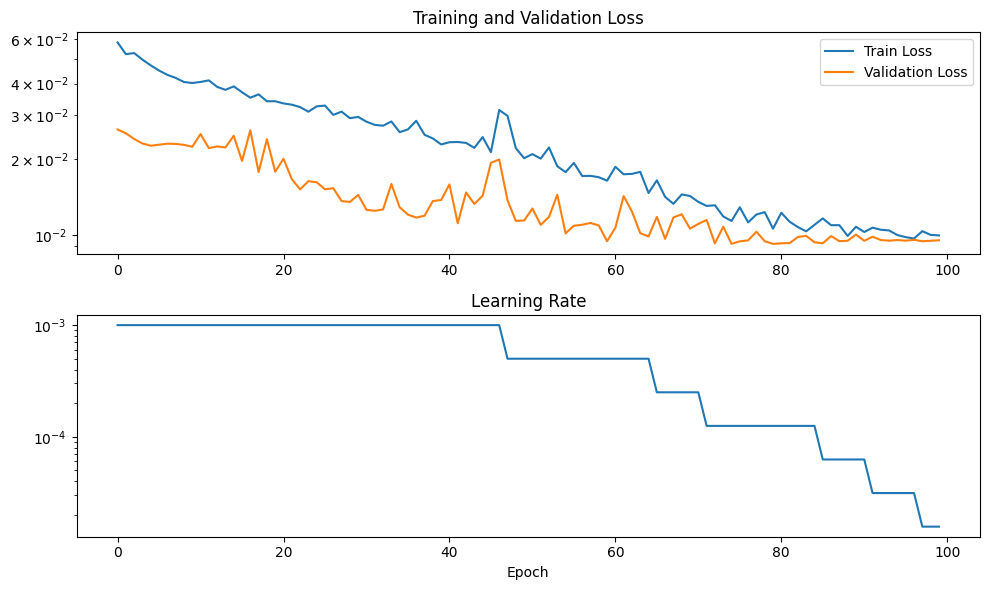

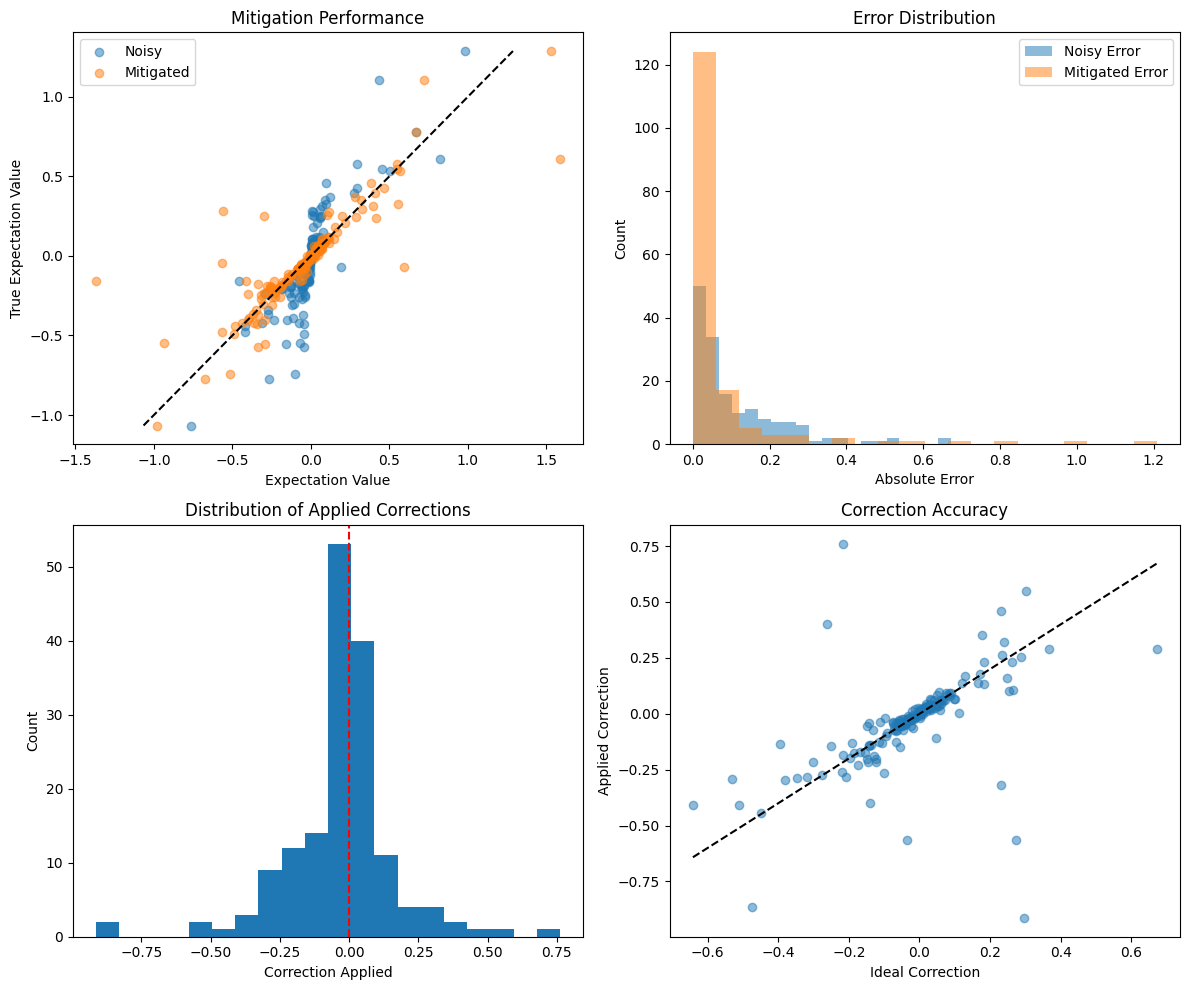

In [8]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # For Apple Silicon
print(f"Using device: {device}")

# Create and train the model
model = QErrorMitigationModel(depth=4)
print("Training error mitigation model...")
trained_model, history = train_mitigator(
    train_dataset, 
    model, 
    epochs=100,  # Adjust based on your needs
    batch_size=16,
    lr=0.001,
    device=device
)

# Evaluate model performance on test data
print("Evaluating model performance on test data...")
predictions, true_values, noisy_values = evaluate_mitigator(trained_model, test_dataset, device=device, output_prefix=output_dir)

# Save the model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'architecture': 'QErrorMitigationModel',
    'creation_date': time.strftime("%Y-%m-%d %H:%M:%S"),
    'noise_factors': noise_factors
}, os.path.join(output_dir, "quantum_error_mitigator.pt"))
print(f"Saved model to {os.path.join(output_dir, 'quantum_error_mitigator.pt')}")

Using device: cpu
Training error mitigation model...


Epoch 1/200, Train Loss: 0.000571, Val Loss: 0.000264, LR: 0.001000, Time: 4.99s


Epoch 10/200, Train Loss: 0.000208, Val Loss: 0.000248, LR: 0.001000, Time: 4.83s


Epoch 20/200, Train Loss: 0.000198, Val Loss: 0.000279, LR: 0.001000, Time: 4.85s


Epoch 30/200, Train Loss: 0.000192, Val Loss: 0.000226, LR: 0.000250, Time: 5.01s


Epoch 40/200, Train Loss: 0.000184, Val Loss: 0.000233, LR: 0.000125, Time: 4.92s


Epoch 50/200, Train Loss: 0.000186, Val Loss: 0.000228, LR: 0.000031, Time: 4.93s


Epoch 60/200, Train Loss: 0.000177, Val Loss: 0.000228, LR: 0.000008, Time: 5.33s


Epoch 70/200, Train Loss: 0.000177, Val Loss: 0.000228, LR: 0.000004, Time: 4.91s


Epoch 80/200, Train Loss: 0.000178, Val Loss: 0.000227, LR: 0.000001, Time: 4.96s


Epoch 90/200, Train Loss: 0.000183, Val Loss: 0.000228, LR: 0.000000, Time: 5.10s


Epoch 100/200, Train Loss: 0.000183, Val Loss: 0.000227, LR: 0.000000, Time: 5.20s


Epoch 110/200, Train Loss: 0.000177, Val Loss: 0.000227, LR: 0.000000, Time: 5.18s


Epoch 120/200, Train Loss: 0.000179, Val Loss: 0.000227, LR: 0.000000, Time: 5.25s


Epoch 130/200, Train Loss: 0.000179, Val Loss: 0.000227, LR: 0.000000, Time: 5.80s


Epoch 140/200, Train Loss: 0.000184, Val Loss: 0.000227, LR: 0.000000, Time: 5.38s


Epoch 150/200, Train Loss: 0.000181, Val Loss: 0.000227, LR: 0.000000, Time: 5.47s


Epoch 160/200, Train Loss: 0.000180, Val Loss: 0.000227, LR: 0.000000, Time: 5.34s


Epoch 170/200, Train Loss: 0.000181, Val Loss: 0.000227, LR: 0.000000, Time: 5.47s


Epoch 180/200, Train Loss: 0.000183, Val Loss: 0.000227, LR: 0.000000, Time: 5.37s


Epoch 190/200, Train Loss: 0.000176, Val Loss: 0.000227, LR: 0.000000, Time: 5.43s


Epoch 200/200, Train Loss: 0.000171, Val Loss: 0.000228, LR: 0.000000, Time: 5.40s
Evaluating model performance on test data...

Error Mitigation Results:
  Mean noisy error: 0.010708
  Mean mitigated error: 0.010210
  Error reduction: 4.65%
  Mean correction applied: 0.005434
Saved model to ml_mitigation_output/noise_factor_3.0/quantum_error_mitigator.pt


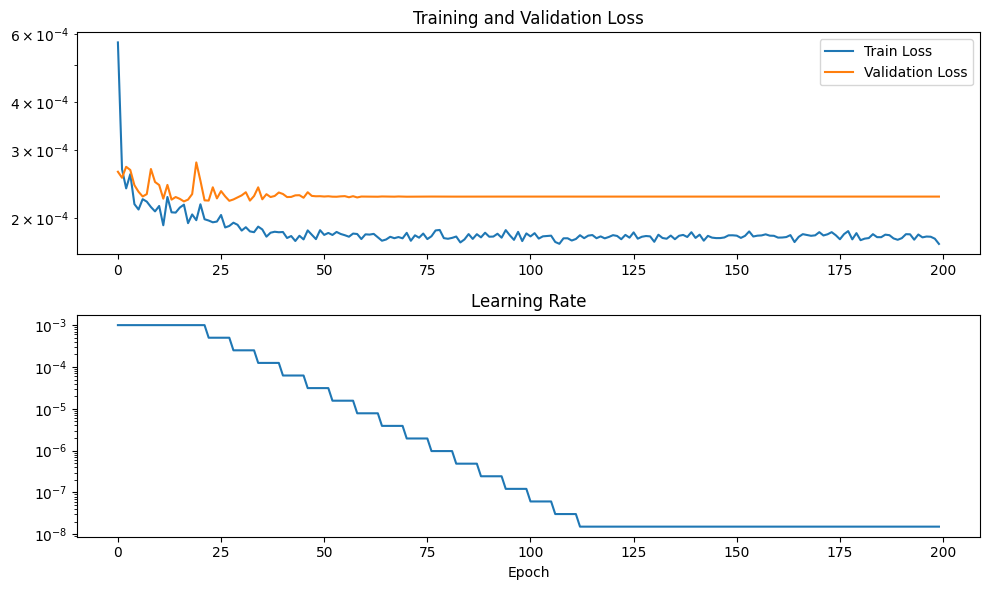

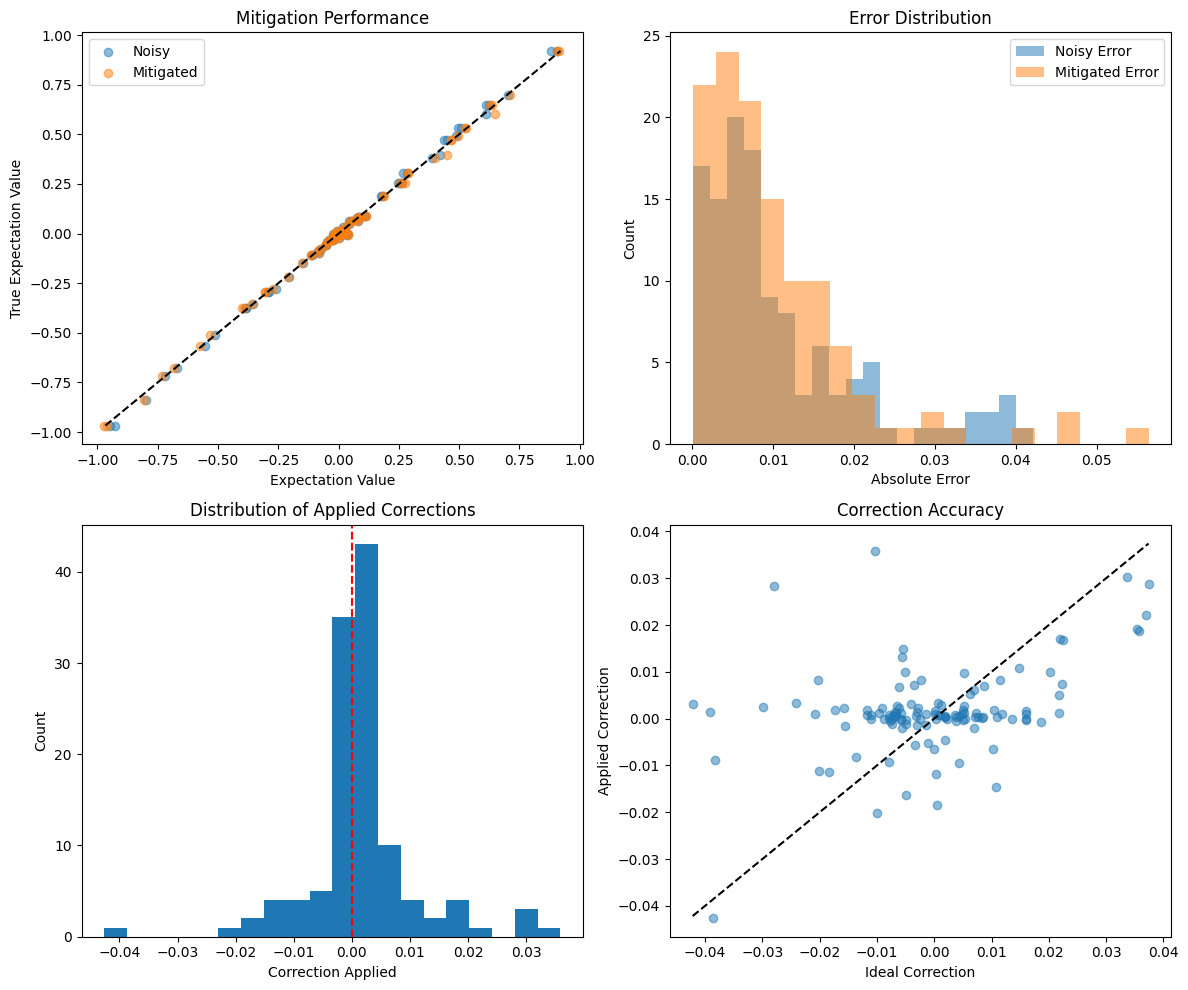

In [ ]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # For Apple Silicon
print(f"Using device: {device}")

# Create and train the model
model = QErrorMitigationModel(depth=4)
print("Training error mitigation model...")
trained_model, history = train_mitigator(
    train_dataset, 
    model, 
    epochs=200,  # Adjust based on your needs
    batch_size=16,
    lr=0.001,
    device=device
)

# Evaluate model performance on test data
print("Evaluating model performance on test data...")
predictions, true_values, noisy_values = evaluate_mitigator(trained_model, test_dataset, device=device, output_prefix=output_dir)

# Save the model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'architecture': 'QErrorMitigationModel',
    'creation_date': time.strftime("%Y-%m-%d %H:%M:%S"),
    'noise_factors': noise_factors
}, os.path.join(output_dir, "quantum_error_mitigator.pt"))
print(f"Saved model to {os.path.join(output_dir, 'quantum_error_mitigator.pt')}")

Using device: cpu
Training error mitigation model...


Epoch 1/200, Train Loss: 0.000571, Val Loss: 0.000264, LR: 0.001000, Time: 4.99s


Epoch 10/200, Train Loss: 0.000208, Val Loss: 0.000248, LR: 0.001000, Time: 4.83s


Epoch 20/200, Train Loss: 0.000198, Val Loss: 0.000279, LR: 0.001000, Time: 4.85s


Epoch 30/200, Train Loss: 0.000192, Val Loss: 0.000226, LR: 0.000250, Time: 5.01s


Epoch 40/200, Train Loss: 0.000184, Val Loss: 0.000233, LR: 0.000125, Time: 4.92s


Epoch 50/200, Train Loss: 0.000186, Val Loss: 0.000228, LR: 0.000031, Time: 4.93s


Epoch 60/200, Train Loss: 0.000177, Val Loss: 0.000228, LR: 0.000008, Time: 5.33s


Epoch 70/200, Train Loss: 0.000177, Val Loss: 0.000228, LR: 0.000004, Time: 4.91s


Epoch 80/200, Train Loss: 0.000178, Val Loss: 0.000227, LR: 0.000001, Time: 4.96s


Epoch 90/200, Train Loss: 0.000183, Val Loss: 0.000228, LR: 0.000000, Time: 5.10s


Epoch 100/200, Train Loss: 0.000183, Val Loss: 0.000227, LR: 0.000000, Time: 5.20s


Epoch 110/200, Train Loss: 0.000177, Val Loss: 0.000227, LR: 0.000000, Time: 5.18s


Epoch 120/200, Train Loss: 0.000179, Val Loss: 0.000227, LR: 0.000000, Time: 5.25s


Epoch 130/200, Train Loss: 0.000179, Val Loss: 0.000227, LR: 0.000000, Time: 5.80s


Epoch 140/200, Train Loss: 0.000184, Val Loss: 0.000227, LR: 0.000000, Time: 5.38s


Epoch 150/200, Train Loss: 0.000181, Val Loss: 0.000227, LR: 0.000000, Time: 5.47s


Epoch 160/200, Train Loss: 0.000180, Val Loss: 0.000227, LR: 0.000000, Time: 5.34s


Epoch 170/200, Train Loss: 0.000181, Val Loss: 0.000227, LR: 0.000000, Time: 5.47s


Epoch 180/200, Train Loss: 0.000183, Val Loss: 0.000227, LR: 0.000000, Time: 5.37s


Epoch 190/200, Train Loss: 0.000176, Val Loss: 0.000227, LR: 0.000000, Time: 5.43s


Epoch 200/200, Train Loss: 0.000171, Val Loss: 0.000228, LR: 0.000000, Time: 5.40s
Evaluating model performance on test data...

Error Mitigation Results:
  Mean noisy error: 0.010708
  Mean mitigated error: 0.010210
  Error reduction: 4.65%
  Mean correction applied: 0.005434
Saved model to ml_mitigation_output/noise_factor_3.0/quantum_error_mitigator.pt


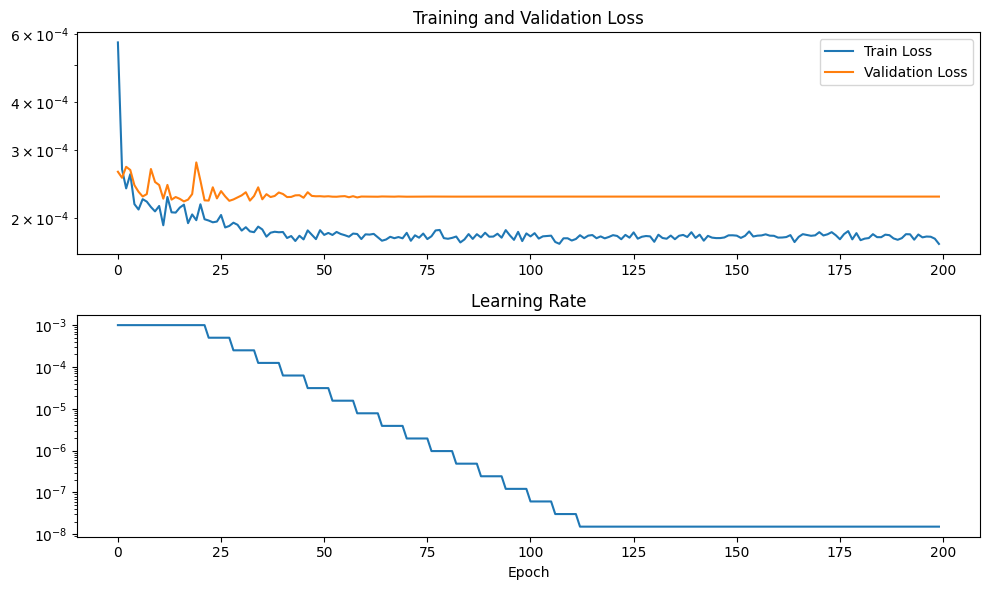

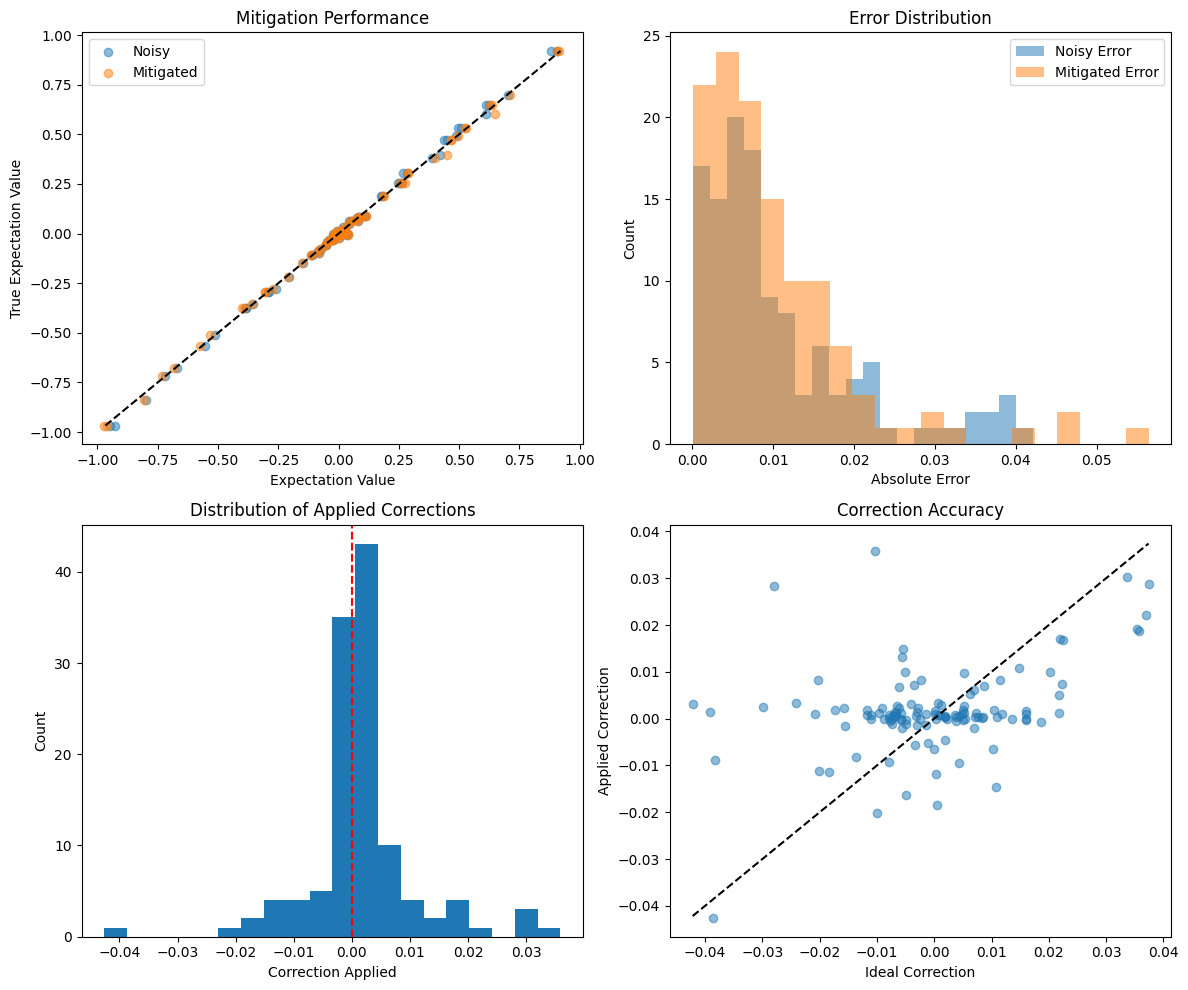

In [7]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # For Apple Silicon
print(f"Using device: {device}")

# Create and train the model
model = QErrorMitigationModel(depth=4)
print("Training error mitigation model...")
trained_model, history = train_mitigator(
    train_dataset, 
    model, 
    epochs=200,  # Adjust based on your needs
    batch_size=16,
    lr=0.001,
    device=device
)

# Evaluate model performance on test data
print("Evaluating model performance on test data...")
predictions, true_values, noisy_values = evaluate_mitigator(trained_model, test_dataset, device=device, output_prefix=output_dir)

# Save the model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'architecture': 'QErrorMitigationModel',
    'creation_date': time.strftime("%Y-%m-%d %H:%M:%S"),
    'noise_factors': noise_factors
}, os.path.join(output_dir, "quantum_error_mitigator.pt"))
print(f"Saved model to {os.path.join(output_dir, 'quantum_error_mitigator.pt')}")


Evaluating model on noise_factor=0.1...
Running noiseless simulations...
Running noisy simulations...
Summary statistics for noise_factor=0.1:
  Mean absolute error: 0.015432
  Max absolute error: 0.199392
  Min absolute error: 0.000034
  Standard deviation of error: 0.024429
Preparing dataset for noise_factor=0.1...
Evaluating model on noise_factor=0.1...

Error Mitigation Results:
  Mean noisy error: 0.015432
  Mean mitigated error: 0.017068
  Error reduction: -10.60%
  Mean correction applied: 0.019662

Evaluating model on noise_factor=0.3...
Running noiseless simulations...
Running noisy simulations...
Summary statistics for noise_factor=0.3:
  Mean absolute error: 0.031404
  Max absolute error: 0.526916
  Min absolute error: 0.000067
  Standard deviation of error: 0.062648
Preparing dataset for noise_factor=0.3...
Evaluating model on noise_factor=0.3...

Error Mitigation Results:
  Mean noisy error: 0.031404
  Mean mitigated error: 0.015725
  Error reduction: 49.93%
  Mean correc

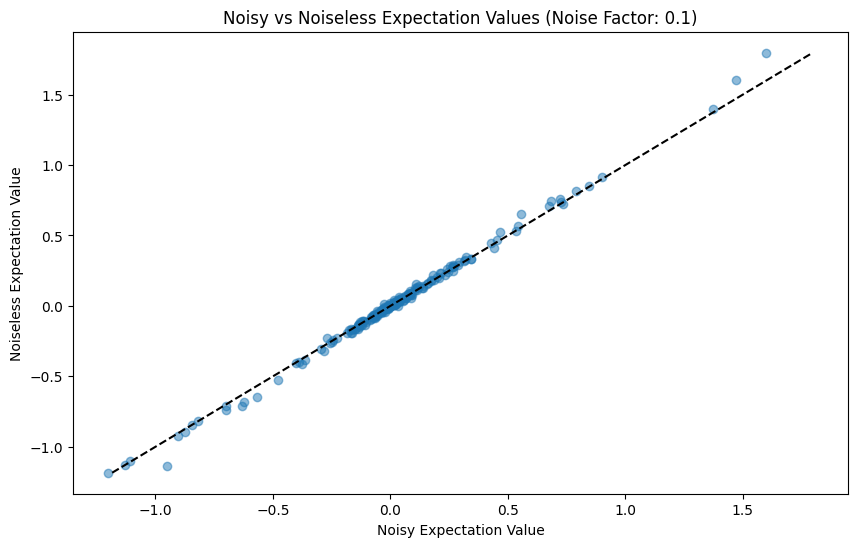

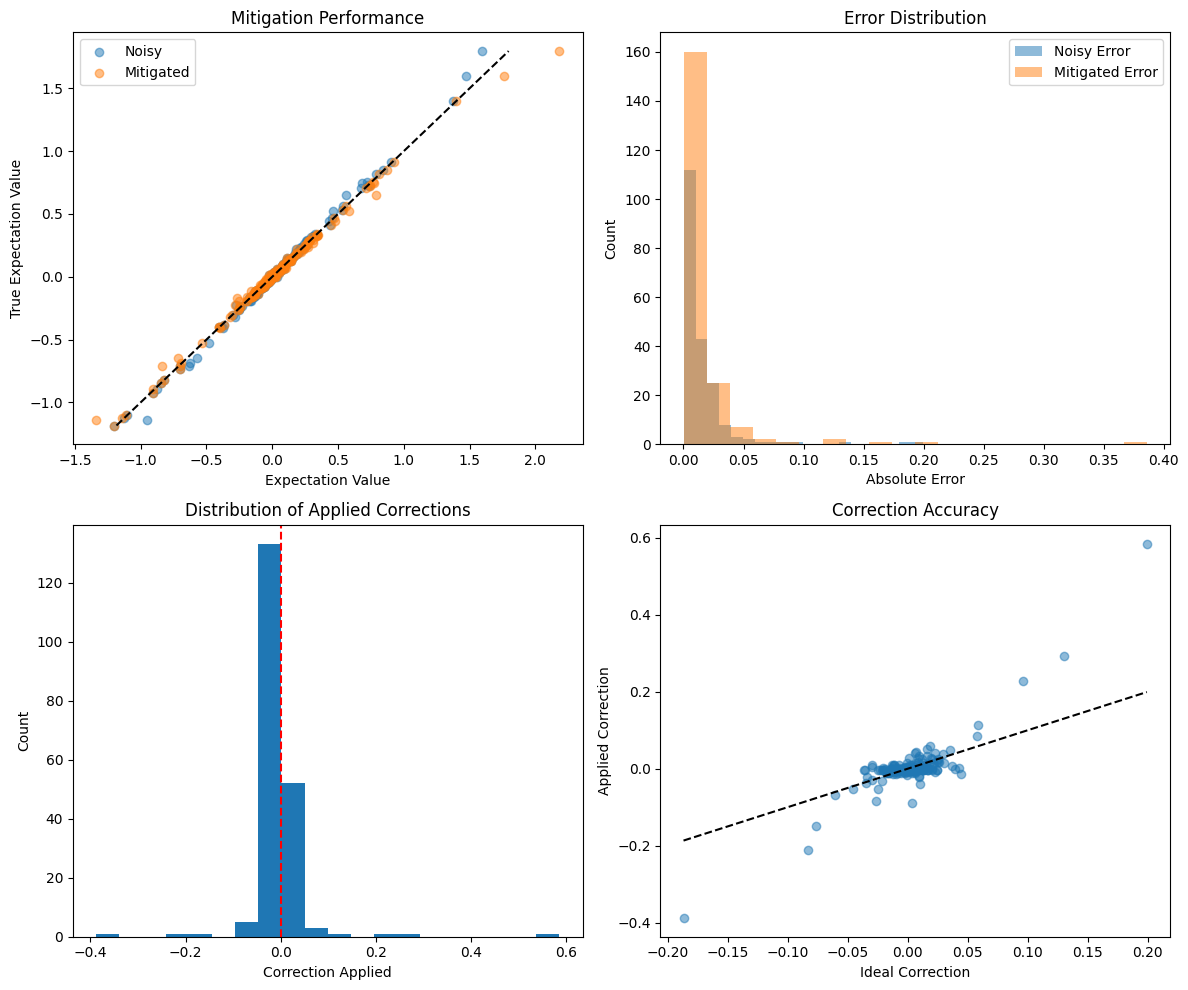

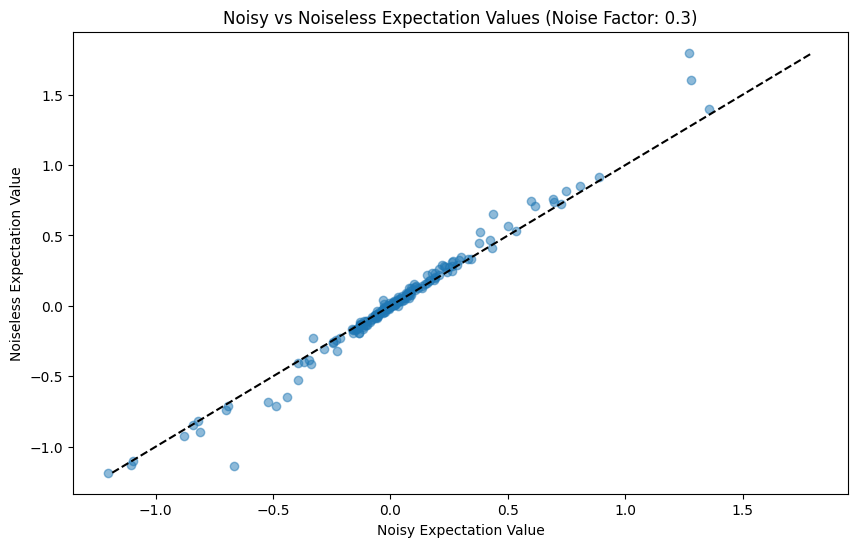

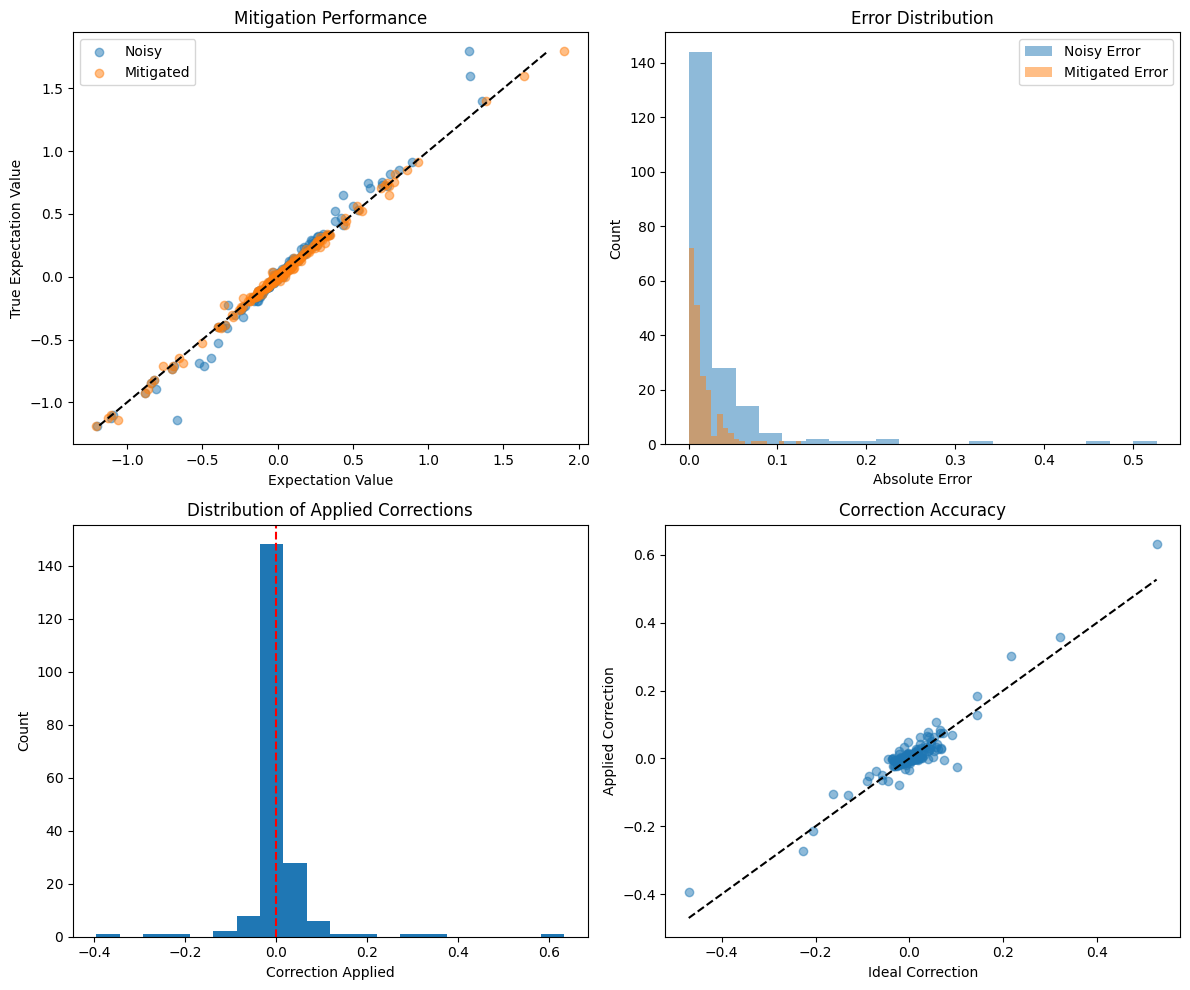

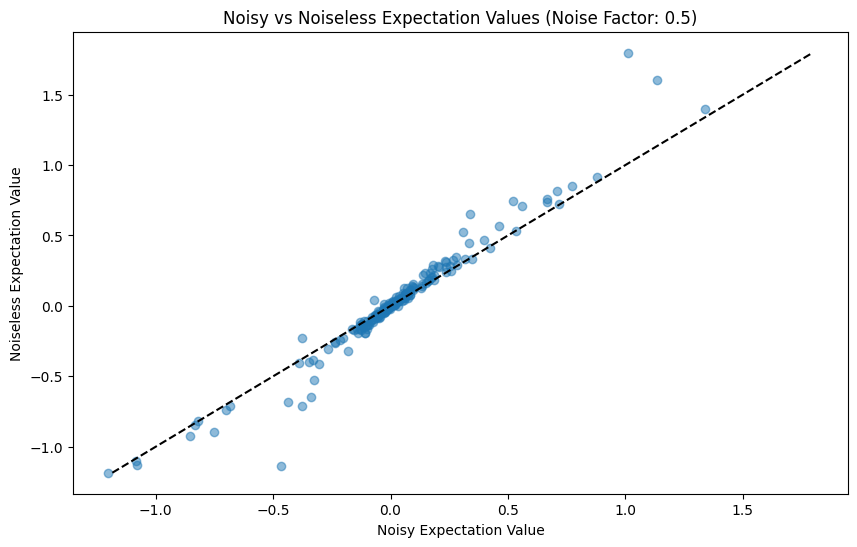

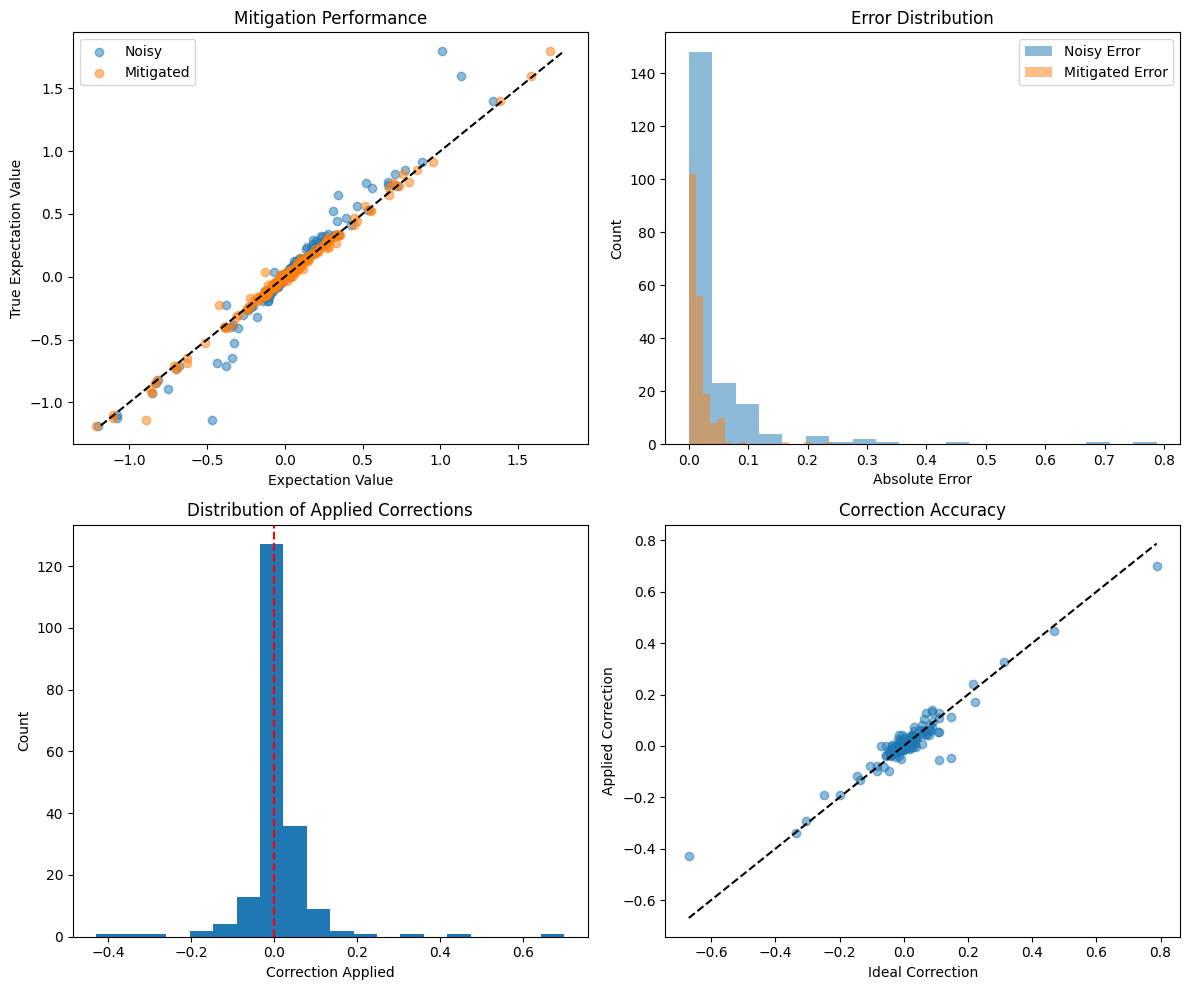

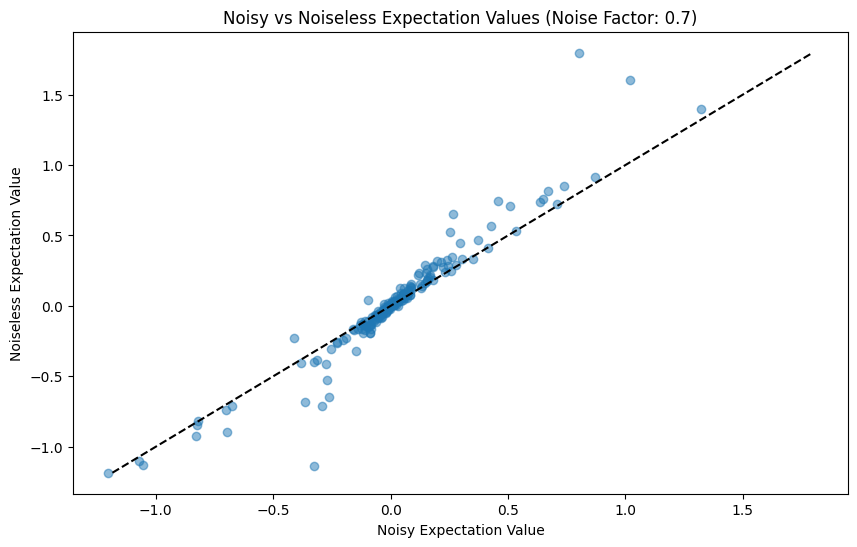

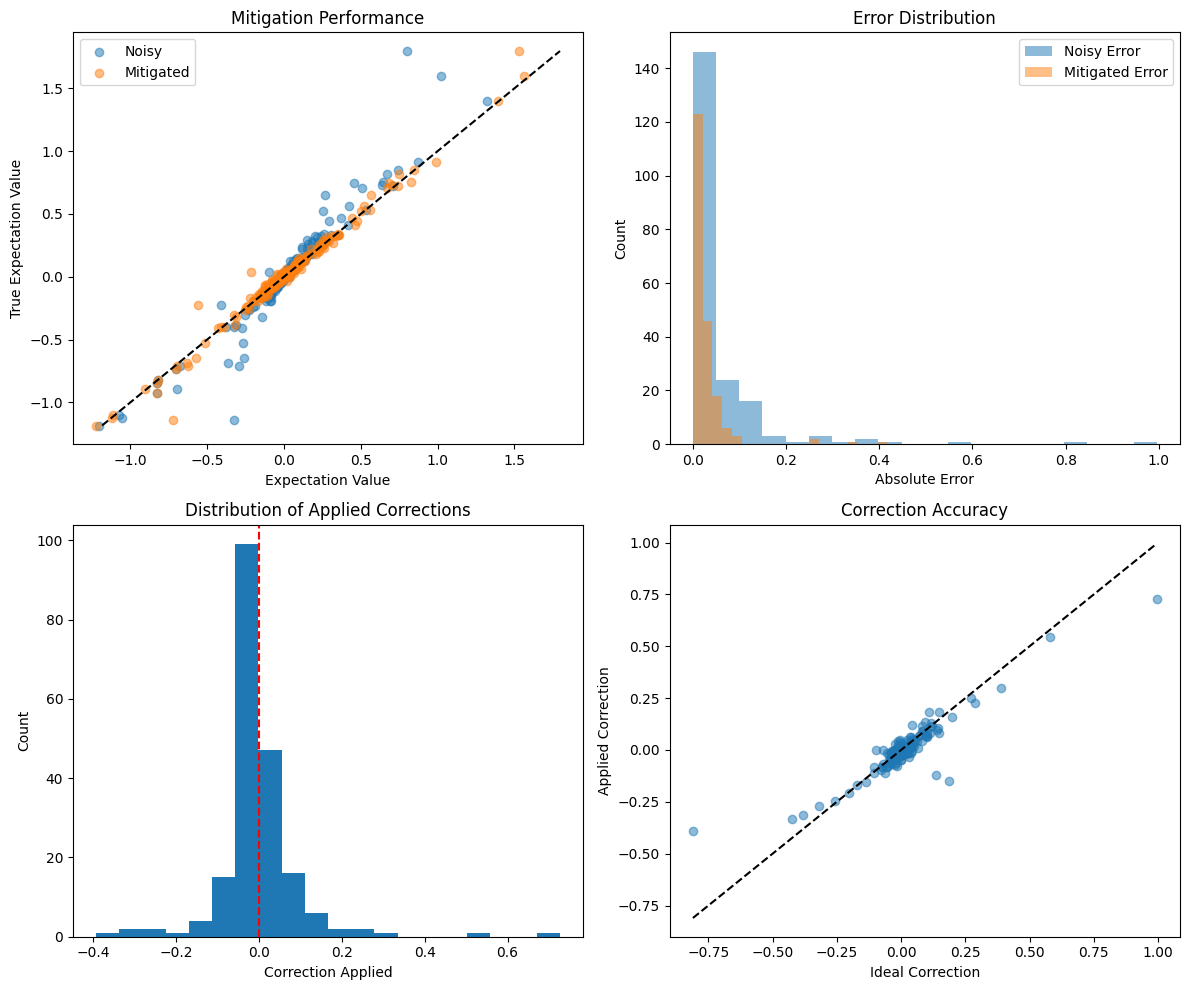

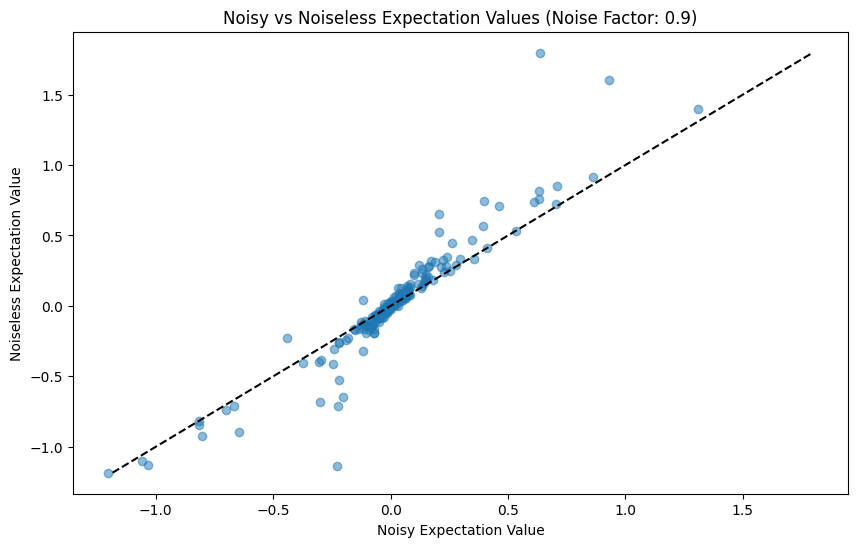

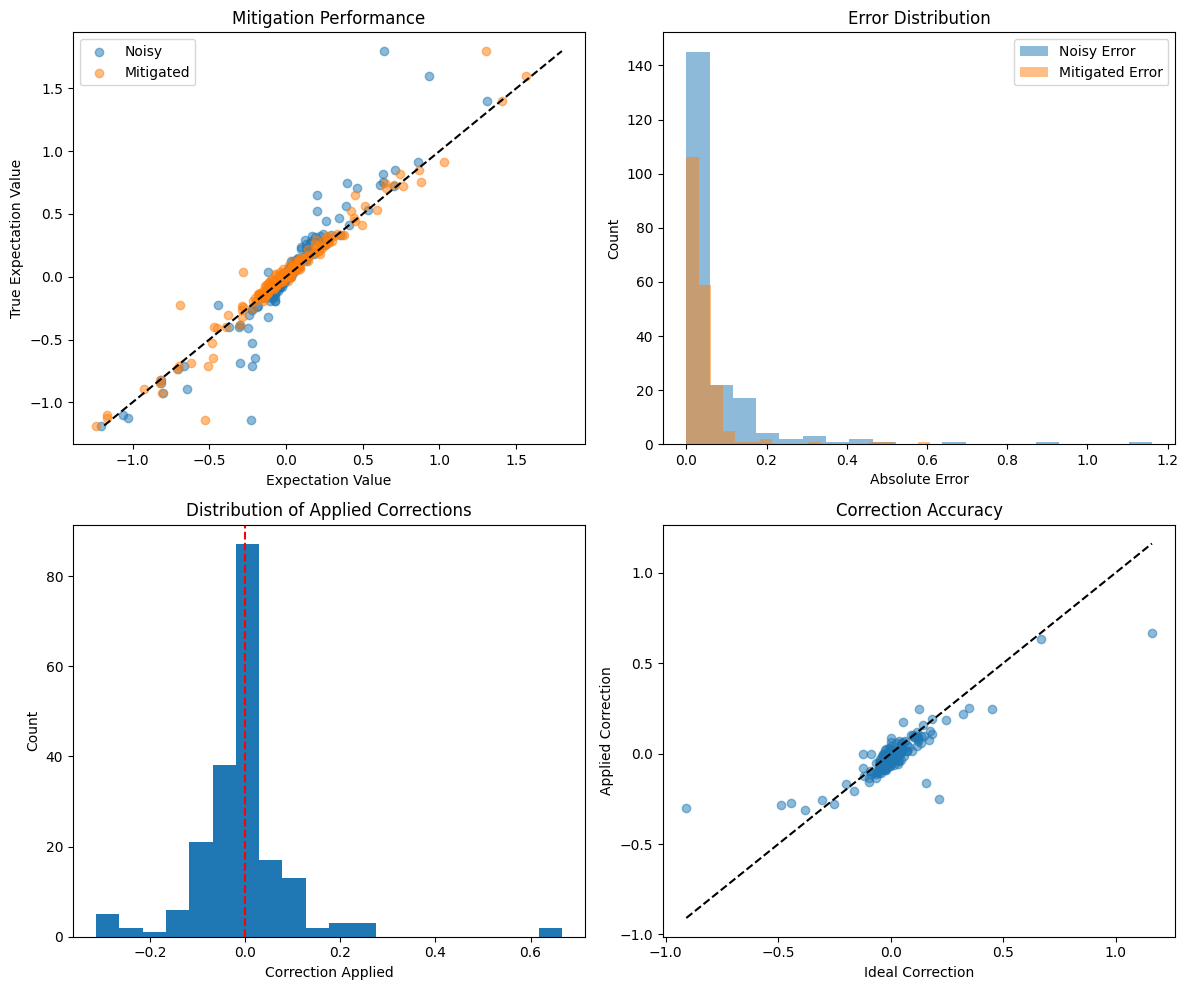

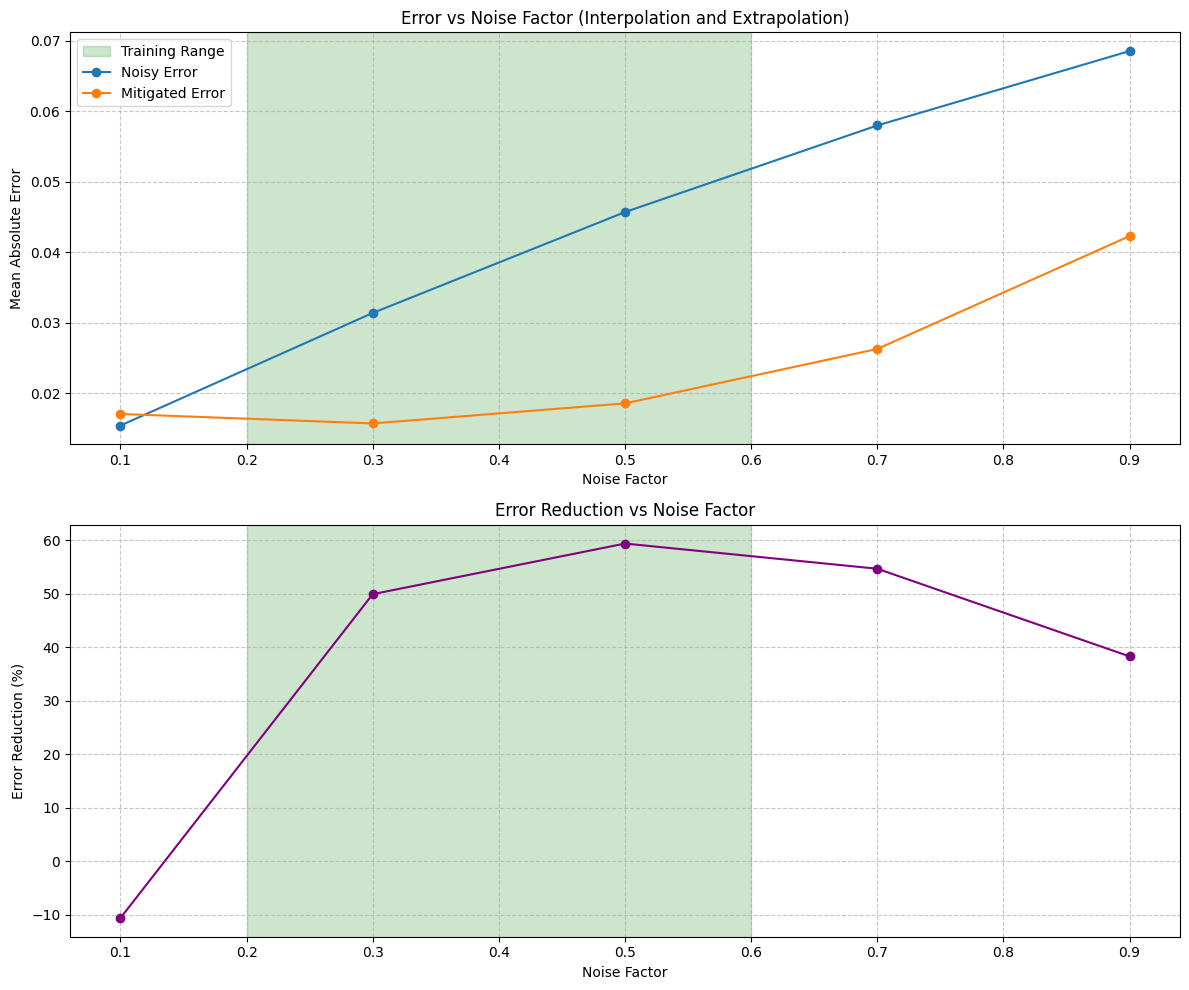

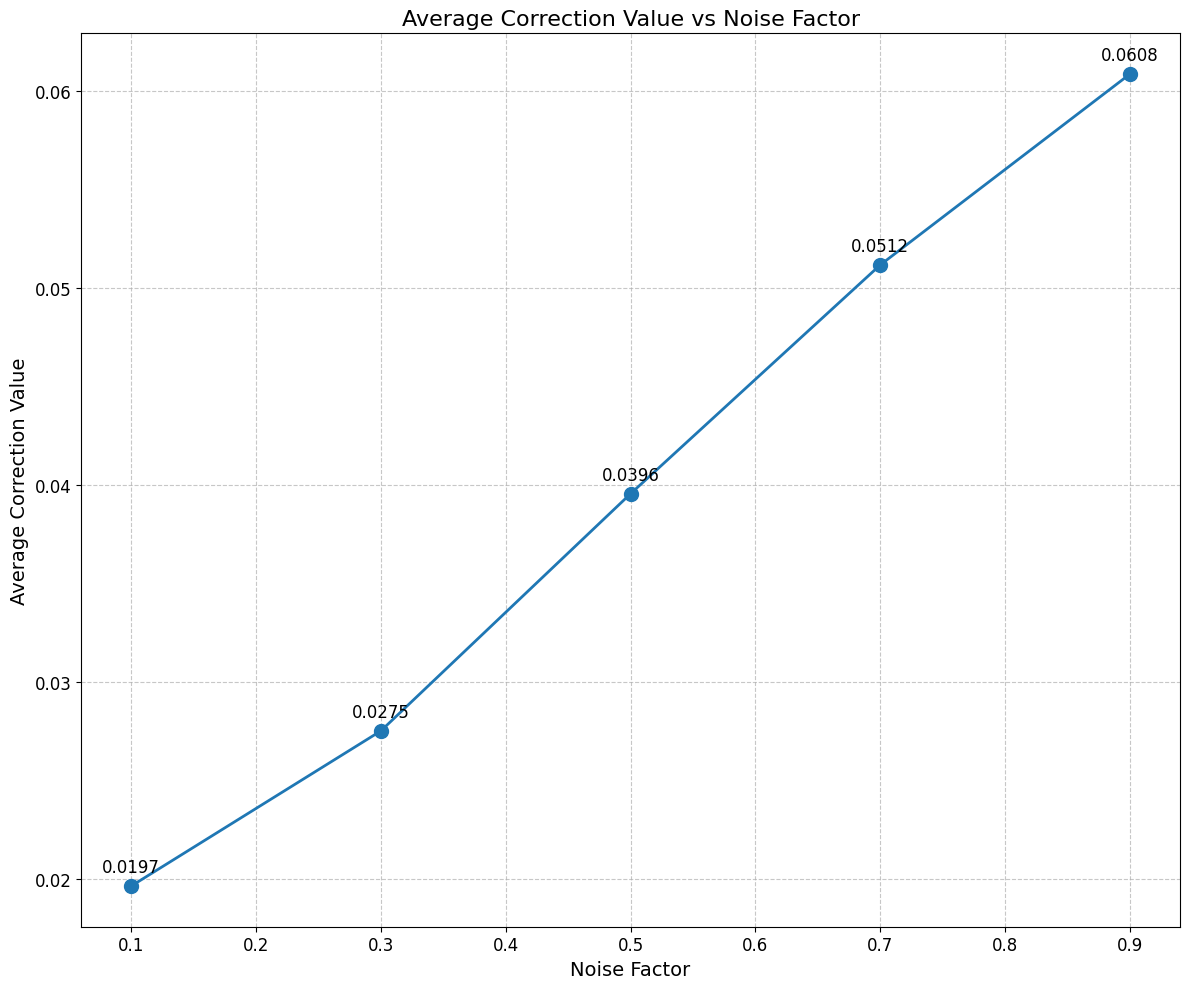

In [21]:
import json

# Evaluate model on different noise factors for interpolation and extrapolation analysis
noise_factors = [0.1, 0.3, 0.5, 0.7, 0.9]  # Lower, in-between, and higher than training values
results = []

for noise_factor in noise_factors:
    print(f"\nEvaluating model on noise_factor={noise_factor}...")

    output_dir = f"ml_mitigation_output/noise_factor_{noise_factor}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate proper circuits
    circuits = generate_proper_circuits(
        num_circuits=num_circuits,
        min_qubits=min_qubits,
        max_qubits=max_qubits,
        min_depth=min_depth,
        max_depth=max_depth,
        seed=seed,
        circuit_types=circuit_types
    )

    observables = generate_proper_observables(circuits, seed=seed)

    noise_model = get_quera_noise_model(noise_factor)

    noiseless_estimator_options = {
        "run_options": {"seed": seed, "shots": None},
        "backend_options": {
            "method": "statevector",
            "enable_truncation": True,
            "device": "CPU",
            "noise_model": None,
            "shots": None,
        },
        "transpile_options": {"seed_transpiler": seed},
        "approximation": True,
    }

    noisy_estimator_options = {
        "run_options": {"seed": seed, "shots": shots},
        "backend_options": {
            "method": "density_matrix",
            "enable_truncation": True,
            "device": "CPU",
            "noise_model": noise_model,
            "shots": shots,
        },
        "transpile_options": {"seed_transpiler": seed},
        "approximation": True,
    }

    # Create estimators
    noiseless_estimator = AerEstimator(**noiseless_estimator_options)
    noisy_estimator = AerEstimator(**noisy_estimator_options)

    # Prepare parameter values (empty for non-parameterized circuits)
    parameter_values = [[] for _ in range(len(circuits))]

    # Run noiseless simulations
    print("Running noiseless simulations...")
    noiseless_job = noiseless_estimator.run(
        circuits=circuits,
        observables=observables,
        parameter_values=parameter_values
    )
    noiseless_result = noiseless_job.result()
    noiseless_values = noiseless_result.values

    # Run noisy simulations
    print("Running noisy simulations...")
    noisy_job = noisy_estimator.run(
        circuits=circuits,
        observables=observables,
        parameter_values=parameter_values
    )
    noisy_result = noisy_job.result()
    noisy_values = noisy_result.values

    noiseless_val_list = []
    noisy_val_list = []

    for i, (circuit, observable, noisy_val, noiseless_val) in enumerate(
        zip(circuits, observables, noisy_values, noiseless_values)
    ):
        noiseless_val_list.append(float(noiseless_val))
        noisy_val_list.append(float(noisy_val))

    # Print summary statistics
    error = np.abs(np.array(noiseless_val_list) - np.array(noisy_val_list))
    
    print(f"Summary statistics for noise_factor={noise_factor}:")
    print(f"  Mean absolute error: {np.mean(error):.6f}")
    print(f"  Max absolute error: {np.max(error):.6f}")
    print(f"  Min absolute error: {np.min(error):.6f}")
    print(f"  Standard deviation of error: {np.std(error):.6f}")

    # Create visualization for this noise factor
    plt.figure(figsize=(10, 6))
    plt.scatter(noisy_val_list, noiseless_val_list, alpha=0.5)
    plt.plot([min(noiseless_val_list), max(noiseless_val_list)], 
              [min(noiseless_val_list), max(noiseless_val_list)], 'k--')
    plt.xlabel("Noisy Expectation Value")
    plt.ylabel("Noiseless Expectation Value")
    plt.title(f"Noisy vs Noiseless Expectation Values (Noise Factor: {noise_factor})")
    plt.savefig(os.path.join(output_dir, f"expectation_values_nf_{noise_factor}.png"))
    
    # Convert data to the format needed for the DAG-based model
    print(f"Preparing dataset for noise_factor={noise_factor}...")
    dataset = prepare_mitigator_dataset(
        circuits, 
        observables, 
        noisy_val_list, 
        noiseless_val_list, 
        noise_factor
    )

    # Evaluate model on this dataset
    print(f"Evaluating model on noise_factor={noise_factor}...")
    predictions, true_values, noisy_values = evaluate_mitigator(trained_model, dataset, device=device, output_prefix=output_dir)
    
    # Calculate errors
    noisy_error = np.abs(np.array(true_values) - np.array(noisy_values))
    mitigated_error = np.abs(np.array(true_values) - np.array(predictions))
    error_reduction = (1 - np.mean(mitigated_error)/np.mean(noisy_error))*100
    
    # Store results
    results.append({
        'noise_factor': noise_factor,
        'noisy_error': np.mean(noisy_error),
        'mitigated_error': np.mean(mitigated_error),
        'error_reduction': error_reduction,
        'is_interpolation': 0.2 <= noise_factor <= 0.6  # True if within training range
    })

# Create summary visualization for interpolation/extrapolation analysis
plt.figure(figsize=(12, 10))

# Plot 1: Error vs Noise Factor
plt.subplot(2, 1, 1)
noise_factors = [r['noise_factor'] for r in results]
noisy_errors = [r['noisy_error'] for r in results]
mitigated_errors = [r['mitigated_error'] for r in results]

# Highlight training region
plt.axvspan(0.2, 0.6, alpha=0.2, color='green', label='Training Range')

plt.plot(noise_factors, noisy_errors, 'o-', label='Noisy Error')
plt.plot(noise_factors, mitigated_errors, 'o-', label='Mitigated Error')
plt.xlabel('Noise Factor')
plt.ylabel('Mean Absolute Error')
plt.title('Error vs Noise Factor (Interpolation and Extrapolation)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Error Reduction vs Noise Factor
plt.subplot(2, 1, 2)
error_reductions = [r['error_reduction'] for r in results]

# Highlight training region
plt.axvspan(0.2, 0.6, alpha=0.2, color='green', label='Training Range')

plt.plot(noise_factors, error_reductions, 'o-', color='purple')
plt.xlabel('Noise Factor')
plt.ylabel('Error Reduction (%)')
plt.title('Error Reduction vs Noise Factor')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "interpolation_extrapolation_analysis.png"))
print(f"Saved interpolation/extrapolation analysis to {os.path.join(output_dir, 'interpolation_extrapolation_analysis.png')}")


# Plot average correction value vs noise factor
print("Plotting average correction value vs noise factor...")
avg_corrections = []

for noise_factor in noise_factors:
    output_dir = f"ml_mitigation_output/noise_factor_{noise_factor}"
    eval_results_path = os.path.join(output_dir, "evaluation_results.json")
    
    try:
        with open(eval_results_path, 'r') as f:
            eval_results = json.load(f)
        
        corrections = eval_results.get("corrections", [])
        if corrections:
            avg_correction = np.mean(np.abs(corrections))
            avg_corrections.append(avg_correction)
            print(f"  Noise factor {noise_factor}: Average correction = {avg_correction:.6f}")
        else:
            print(f"  No corrections found for noise factor {noise_factor}")
            avg_corrections.append(0)
    except FileNotFoundError:
        print(f"  Evaluation results file not found for noise factor {noise_factor}")
        avg_corrections.append(0)

# Create the plot
plt.figure(figsize=(12, 10))
plt.plot(noise_factors, avg_corrections, 'o-', linewidth=2, markersize=10)
plt.xlabel("Noise Factor", fontsize=14)
plt.ylabel("Average Correction Value", fontsize=14)
plt.title("Average Correction Value vs Noise Factor", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add data points labels
for i, (x, y) in enumerate(zip(noise_factors, avg_corrections)):
    plt.annotate(f"{y:.4f}", (x, y), textcoords="offset points", 
                 xytext=(0, 10), ha='center', fontsize=12)

plt.tight_layout()
# plt.savefig(os.path.join("ml_mitigation_output", "avg_correction_vs_noise_factor.png"))
print(f"Saved average correction plot to ml_mitigation_output/avg_correction_vs_noise_factor.png")


In [5]:
from torchviz import make_dot

# Create a dummy input for each component
batch_size = 1
dummy_x = torch.randn(10, 17)  # 10 nodes with 17 features
dummy_edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]]) # Example edges
dummy_batch = torch.zeros(10, dtype=torch.long)  # All nodes in same graph

dummy_circuit_data = Data(x=dummy_x, edge_index=dummy_edge_index, batch=dummy_batch)
dummy_observable = torch.randn(batch_size, 5)
dummy_noise = torch.randn(batch_size, 1)
dummy_noisy_exp = torch.randn(batch_size, 1)

model = QErrorMitigationModel()
output = model(dummy_circuit_data, dummy_observable, dummy_noise, dummy_noisy_exp)

# Generate the graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")

'model_architecture.png'

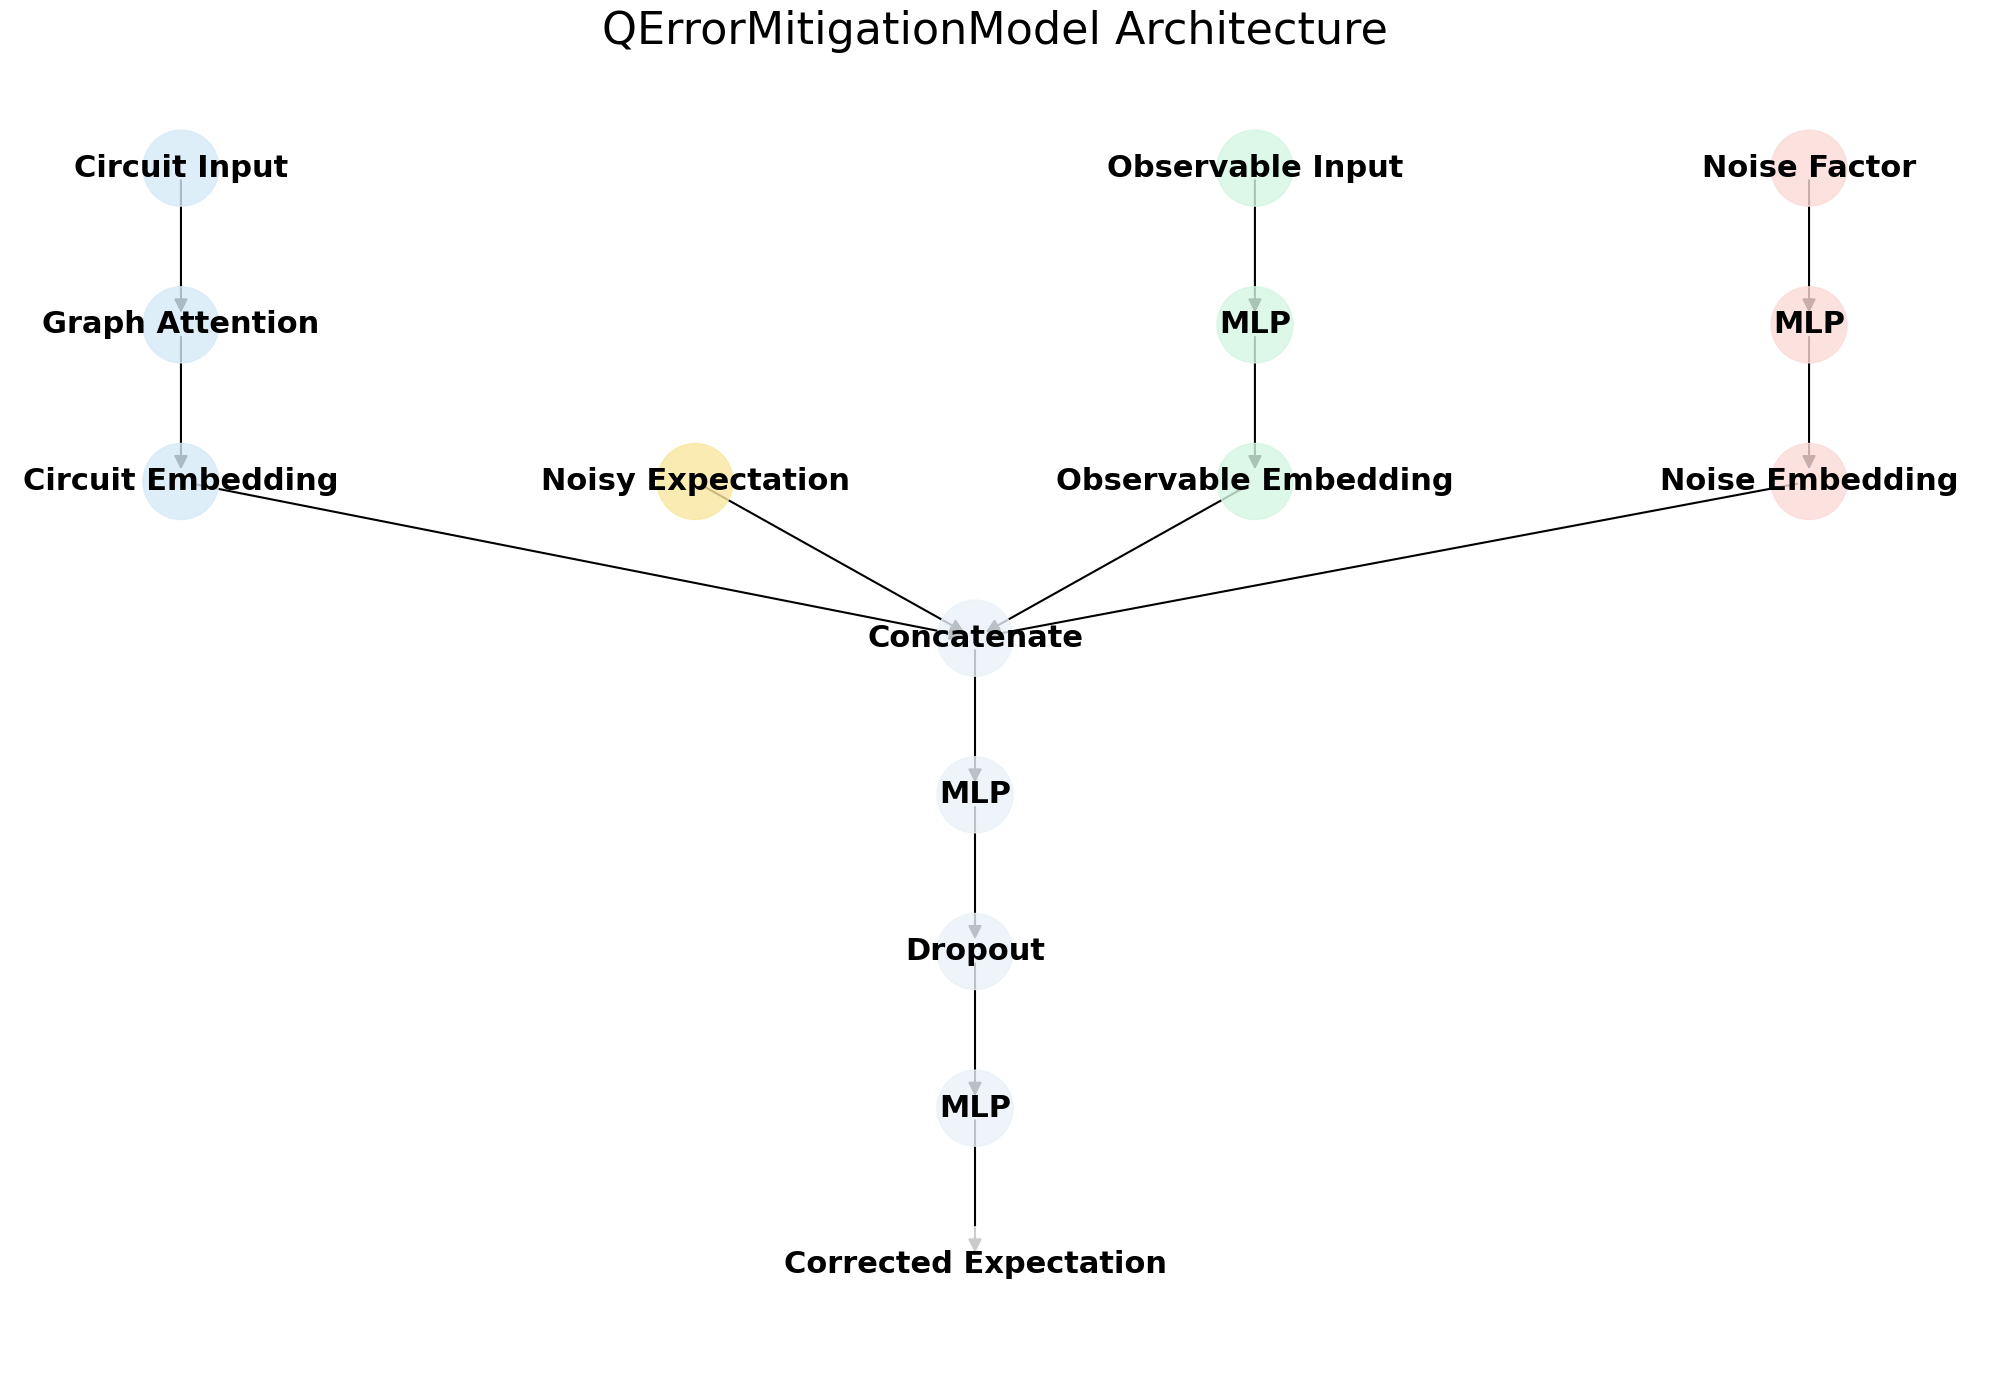

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes for each component with simplified labels
modules = {
    # Main components
    "circuit_input": "Circuit Input",
    "observable_input": "Observable Input",
    "noise_input": "Noise Factor",
    "noisy_exp": "Noisy Expectation",
    
    # Circuit path
    "gat1": "Graph Attention",
    "circuit_emb": "Circuit Embedding",
    
    # Observable path
    "obs_lin1": "MLP",
    "obs_emb": "Observable Embedding",
    
    # Noise path
    "noise_lin": "MLP",
    "noise_emb": "Noise Embedding",
    
    # Fusion network
    "concat": "Concatenate",
    "fusion1": "MLP",
    "dropout": "Dropout",
    "fusion2": "MLP",
    "output": "Corrected Expectation"
}

# Add nodes with labels
for name, label in modules.items():
    G.add_node(name, label=label)

# Add edges
edges = [
    # Circuit path
    ("circuit_input", "gat1"), ("gat1", "circuit_emb"), ("circuit_emb", "concat"),
    
    # Observable path
    ("observable_input", "obs_lin1"),
    ("obs_lin1", "obs_emb"), ("obs_emb", "concat"),
    
    # Noise path
    ("noise_input", "noise_lin"), ("noise_lin", "noise_emb"), ("noise_emb", "concat"),
    
    # Noisy expectation
    ("noisy_exp", "concat"),
    
    # Fusion path
    ("concat", "fusion1"), ("fusion1", "dropout"), ("dropout", "fusion2"),  ("fusion2", "output")
]

G.add_edges_from(edges)

# Create plot
plt.figure(figsize=(20, 14))  # Increased figure size
# Use a more compact layout
pos = nx.nx_pydot.pydot_layout(G, prog="dot")

# Define node colors by group
node_colors = {
    'circuit': '#D6EAF8',  # Circuit: light blue
    'obs': '#D5F5E3',      # Observable: light green
    'noise': '#FADBD8',    # Noise: light red
    'noisy': '#F9E79F',    # Yellow
    'fusion': '#EAF2F8',   # Light blue
    'other': '#FFFFFF'     # White
}

colors = []
for node in G.nodes():
    if any(x in node for x in ['circuit', 'gat', 'global_pool']):
        colors.append(node_colors['circuit'])
    elif 'obs' in node:
        colors.append(node_colors['obs'])
    elif 'noise' in node:
        colors.append(node_colors['noise'])
    elif 'noisy_exp' in node:
        colors.append(node_colors['noisy'])
    elif any(x in node for x in ['fusion', 'dropout', 'concat']):
        colors.append(node_colors['fusion'])
    else:
        colors.append(node_colors['other'])

# Draw nodes and edges with larger node size
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=1.5)

# Add labels - use node names directly if label attribute is missing
labels = {}
for node in G.nodes():
    if 'label' in G.nodes[node]:
        labels[node] = G.nodes[node]['label']
    else:
        labels[node] = node  # Fallback to node name if label is missing

nx.draw_networkx_labels(G, pos, labels=labels, font_size=22, font_weight='bold')

plt.title("QErrorMitigationModel Architecture", fontsize=32)
plt.axis('off')
plt.tight_layout()
plt.savefig('qem_model_architecture.png', dpi=300)
plt.show()